# TWEET SENTIMENT ANALYSIS FOR DETECTION OF SUICIDALITY AND DISASTER USING Bi-LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
### NB: TO SUCCESSFULLY RUN THIS NOTEBOOK, CHANGE THIS PATH TO THE PATH OF THE PROJECT DIRECTORY ON YOUR DEVICE
%cd /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets

/content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets


## Importing Necessary Libraries

**Project Folder Structure:**

Binary_Classification_of_Tweets/
   - Data/
   - Notebooks/
      - Tweet_Sentiment.ipynb
   - Outputs/
      - Base_Model_Output/
        - Suicide_Disaster_tweet_sentiment_BiLSTM_Model
   - Tweet_Classification_UI.py
   - config.py

NB: The project folder structure should not be altered


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import _preprocessed_data_dir, _data_dir, _save_model_dir, _max_output_sequence, _max_vocab_length
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
import datetime
from collections import Counter
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
import seaborn as sns
from collections import  Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import svm
import pickle
from tensorflow.keras.callbacks import Callback
from config import _Bilstm_model_dir, _dnn_model_dir, _GRU_model_dir, _LSTM_model_dir, _cnn_model_dir

## Data Acquisition

To build a robust model, a web scraping technique was employed to gather an initial dataset of 2,536 tweets, which include categories such as suicide and disaster-related tweets.

In [ ]:
excel_data_path = _data_dir+'PROJECT EXCEL.xlsx'
dataset = pd.read_excel(excel_data_path)

## Data Visualization

In [ ]:
dataset.head()

,DATABASE FOR PROJECT,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,Keeping Charlie's legacy alive.,NaN,NaN,NaN,SUICIDE
2,NaN,NaN,NaN,NaN,SUICIDE
3,22 VETERANS COMMIT SUICIDE EVERY DAY!! #End22,NaN,NaN,NaN,SUICIDE
4,NaN,NaN,NaN,NaN,SUICIDE


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATABASE FOR PROJECT  1344 non-null   object 
 1   Unnamed: 1            0 non-null      float64
 2   Unnamed: 2            0 non-null      float64
 3   Unnamed: 3            0 non-null      float64
 4   Unnamed: 4            2529 non-null   object 
dtypes: float64(3), object(2)
memory usage: 99.1+ KB


In [ ]:
len(dataset)

2535

In [ ]:
dataset.isnull().sum()

DATABASE FOR PROJECT    1191
Unnamed: 1              2535
Unnamed: 2              2535
Unnamed: 3              2535
Unnamed: 4                 6
dtype: int64

The visualization highlights significant data preprocessing requirements, revealing 1191 null features and several empty columns. Addressing these challenges demands the application of appropriate preprocessing techniques to effectively handle them.

## Data Preprocessing

We'll begin the data preprocessing phase here to address the dataset issues and ensure its cleanliness. Subsequently, further preprocessing for modeling purposes will be executed in a Python script, invoked by the training script.

Steps:
* Renaming Column Names
* Dropping Empty Columns
* Dropping Null Samples


#### Renaming Column Names

In [ ]:
dataset.columns

Index(['DATABASE FOR PROJECT', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4'],
      dtype='object')

In [ ]:
dataset.rename(columns={'DATABASE FOR PROJECT': 'text', 'Unnamed: 4':'labels'}, inplace=True)

In [ ]:
dataset.head()

,text,Unnamed: 1,Unnamed: 2,Unnamed: 3,labels
0,NaN,NaN,NaN,NaN,NaN
1,Keeping Charlie's legacy alive.,NaN,NaN,NaN,SUICIDE
2,NaN,NaN,NaN,NaN,SUICIDE
3,22 VETERANS COMMIT SUICIDE EVERY DAY!! #End22,NaN,NaN,NaN,SUICIDE
4,NaN,NaN,NaN,NaN,SUICIDE


#### Dropping Empty Columns

In [ ]:
dataset.drop(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis=1, inplace=True)

In [ ]:
dataset

,text,labels
0,NaN,NaN
1,Keeping Charlie's legacy alive.,SUICIDE
2,NaN,SUICIDE
3,22 VETERANS COMMIT SUICIDE EVERY DAY!! #End22,SUICIDE
4,NaN,SUICIDE
...,...,...
2530,"In another man’s bed, drinking alcohol, flirti...",DISASTER
2531,NaN,DISASTER
2532,let me ask ariana how to wreck homes https://t...,DISASTER
2533,NaN,DISASTER


#### Dropping Null Samples

In [ ]:
dataset.dropna(axis=0, inplace=True)

In [ ]:
dataset.head()

,text,labels
1,Keeping Charlie's legacy alive.,SUICIDE
3,22 VETERANS COMMIT SUICIDE EVERY DAY!! #End22,SUICIDE
5,"Bernie, that should be the number one song in ...",SUICIDE
7,LionsSpectre Always identified with Trunks gro...,SUICIDE
9,what major jewish holiday fell on Oct.7,SUICIDE


#### Save Preprocessed Dataset to Disk

In [ ]:
# Save the preprocessed dataset as csv
path_to_save_preprocessed_dataset = _data_dir+'preprocessed_dataset.xlsx'
dataset.to_excel(path_to_save_preprocessed_dataset)

## Data Visualization/Analysis

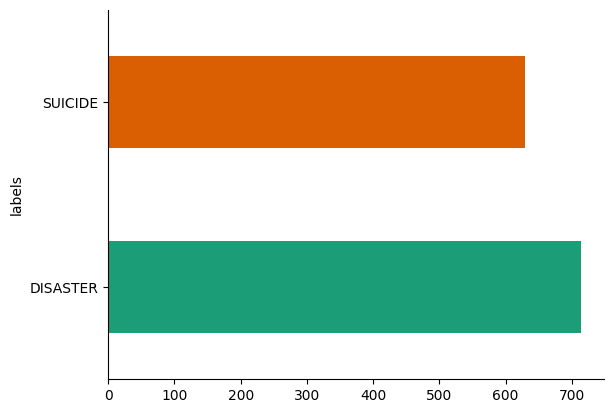

In [ ]:
dataset.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Based on the visualization above, it's evident that we don't need to address class imbalance issues since the dataset exhibits a fairly equal distribution of labels.


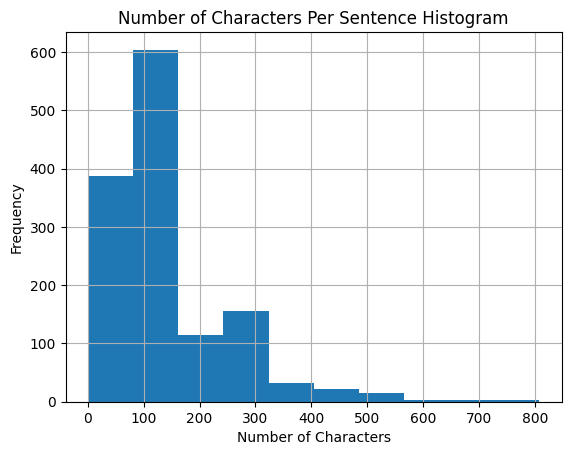

In [ ]:
plt.figure();
dataset['text'].str.len().hist();
plt.title('Number of Characters Per Sentence Histogram');
plt.xlabel('Number of Characters');
plt.ylabel('Frequency');

The histogram shows that the text dataset range from 0 to about 800 characters and generally, it is between 0 to 150 characters.

In [ ]:
# Check for missing values
dataset.isna().sum()

text      0
labels    0
dtype: int64

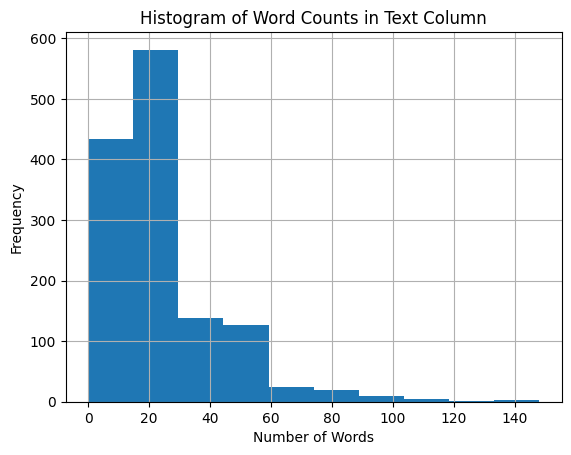

In [ ]:
plt.figure()
dataset['text'] = dataset['text'].fillna('').astype(str)
dataset['text'].str.split().map(lambda x: len(x)).hist()
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Text Column')
plt.show()

This Histogram shows that most sentences have a word count between 0 to 25

In [ ]:
# From the histogram above, it is obvious that there are empty strings in the dataset, let's Visualize the number of empty strings.

# Split the strings into words and count the number of words in each entry
word_counts = dataset['text'].str.split().map(len)

# Identify entries with zero words
zero_word_entries = word_counts[word_counts == 0]
print(f"Number of entries with zero words: {len(zero_word_entries)}")

Number of entries with zero words: 1


In [ ]:
plt.figure();
dataset['text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist();
plt.title('Histogram of Average Word Length');

NameError: name 'plt' is not defined

The average word length ranges between 3 to 12 with 5 being the most common length. The histogram is left skewed, this might be as a result of stopwords present in the dataset, making most word length small in length.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


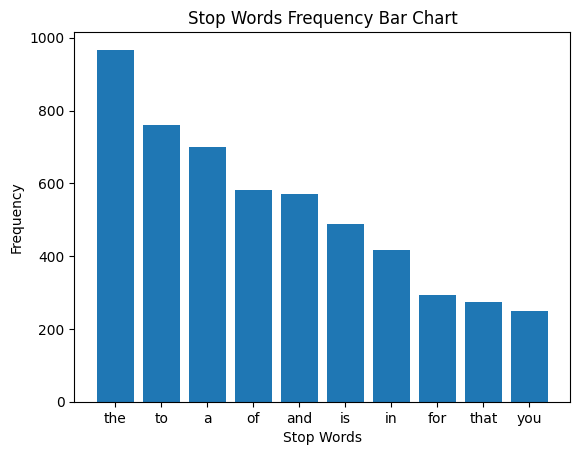

In [ ]:
## Stop Words Analysis
nltk.download('stopwords')

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.bar(x,y)
    plt.xlabel('Stop Words')
    plt.ylabel('Frequency')
    plt.title('Stop Words Frequency Bar Chart')

plot_top_stopwords_barchart(dataset['text'])

We can evidently see that stopwords such as “the”,” to” and “a” dominate in the tweet dataset.

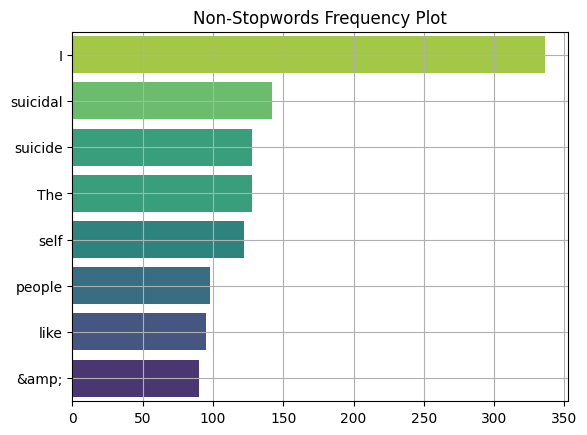

In [ ]:
# Word Level Analysis: Visualization of Non-Stopwords Frequency
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    palette = sns.color_palette("viridis", 7)

    sns.barplot(x=y,y=x, palette=palette, hue=y, legend=False)
    plt.title('Non-Stopwords Frequency Plot')
    plt.grid(True)

plot_top_non_stopwords_barchart(dataset['text'])

From the above Visualization, the words 'I','Suicidal' and 'Suicide' appears the most in tweet dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


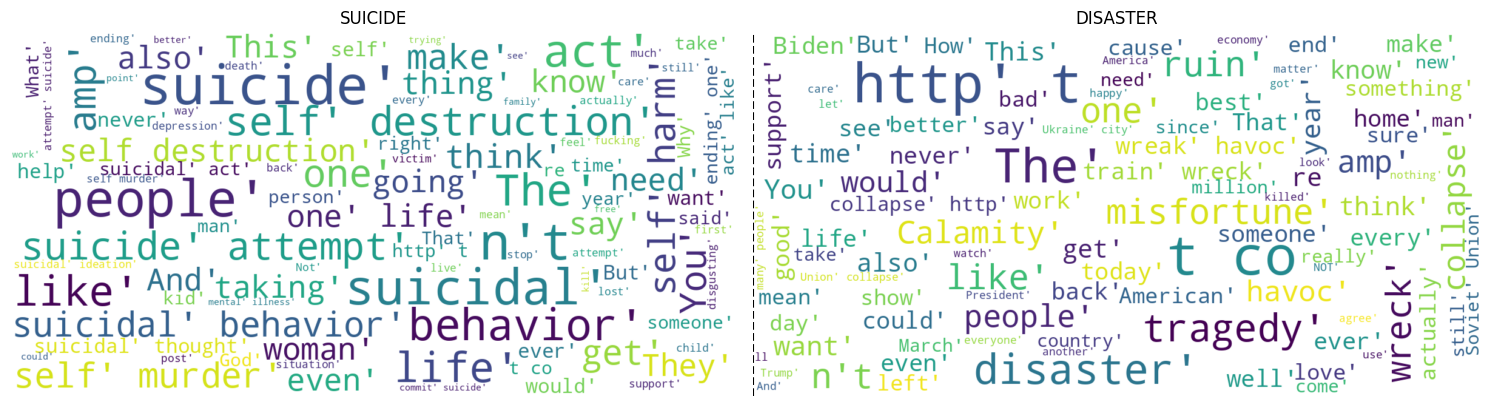

In [ ]:
def plot_wordcloud(text, ax, title):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            # Ensure 'news' is a string
            if isinstance(news, str):
                words = [w for w in word_tokenize(news) if (w not in stop)]

                words = [lem.lemmatize(w) for w in words if len(w) > 2]

                corpus.append(words)
        return corpus

    corpus = _preprocess_text(text)

    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud = wordcloud.generate(str(corpus))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot wordcloud for each label
labels = dataset['labels'].unique()
for i, label in enumerate(labels):
    dataset_for_label = dataset[dataset['labels'] == label]
    plot_wordcloud(dataset_for_label['text'], axs[i], label)

# Add a vertical line between the subplots
plt.axvline(x=0.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

The words which occur frquently are highlighted and have larger size

In [ ]:
sentences = dataset['text']
labels = dataset['labels']

In [ ]:
### Get the average number of tokens, (words) per text in the dataset
average_number_of_tokens = round(sum([len(i.split()) for i in sentences.astype(str)])/len(sentences))
average_number_of_tokens

24

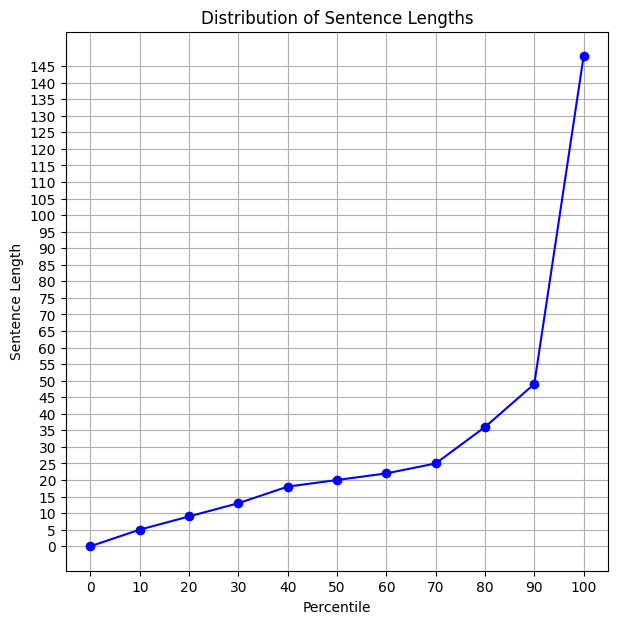

In [ ]:
# Get a list of all the sentence lenghts
sentences_len = [len(i.split()) for i in sentences.astype(str)]

# Calculate percentiles
percentiles = np.arange(0, 101, 10)
percentile_values = np.percentile(sentences_len, percentiles)

# Plot percentiles
plt.figure(figsize=(7, 7))
plt.plot(percentiles, percentile_values, marker='o', color='b')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Percentile')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, max(sentences_len) + 1,5), rotation=360)
plt.show()

From this plot, we see that 90% of the sentences have sentence length equal to 50, or below it. But just 10% have sentence length between 50 to 148, therefore, the max output sequence(max number of words in each sentence), would be set to the 70th percentile, which is 25

## Data Preprocessing

##### 1. Reading in Saved Preprocessed Dataset from Disk
##### 2. Data Cleaning: Removal of Punctuation
##### 3. Tokenization
##### 4. Data Cleaning: Removal of Stop Words
##### 5. Lemmatization
##### 6. Vectorization
##### 7. Embedding
##### 8. Train Test Split

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


class Preprocess():
    @staticmethod
    def train_test_split(X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            np.array(X), np.array(y), stratify=y, test_size=0.2,random_state=42)

        return (X_train, X_test, y_train, y_test)

    @staticmethod
    def remove_punctuations(text):
      # Ensure the text is in string format
      if isinstance(text, bytes):
        text = text.decode('utf-8')
      elif isinstance(text, np.ndarray):
        text = text.astype(str)
      elif isinstance(text, datetime.datetime):
        # convert datetime dtype to string
        text = text.strftime('%Y-%m-%d %H:%M:%S')
        # convert other non text dtype to text
      elif not isinstance(text, str):
        text = str(text)

      # Convert text to lowercase using numpy's char.lower if it is a numpy array
      lowercase_text = text.lower()
      # Remove punctuations using regex
      removed_punctuations = re.sub(r'[^\w\s]', '', lowercase_text)
      return removed_punctuations

    @staticmethod
    def tokenizer(text):
        '''
        This Function performs word level tokenization
        for the input data, using the nltk (Natural Language Processing Toolkit) library
        '''

        return word_tokenize(text)

    @staticmethod
    def remove_stop_words(tokenized_text):
        '''
        This function implements the nltk library to remove stop words
        from the dataset
        '''

        var_stop_words = set(stopwords.words('english'))
        words = tokenized_text
        words_filtered = [word for word in words if word.isalpha()
                          and word not in var_stop_words]

        return words_filtered

    @staticmethod
    def get_wordnet_pos(word):
      """Map POS tag to first character lemmatize() accepts"""
      tag = nltk.pos_tag([word])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}
      return tag_dict.get(tag, wordnet.NOUN)

    @staticmethod
    def lemmatize(text):
      if isinstance(text, list):
        lemmatizer = WordNetLemmatizer()
        words_filtered = [lemmatizer.lemmatize(word, Preprocess.get_wordnet_pos(word)) for word in text]
        return words_filtered
      else:
        raise ValueError('Input should be a list of words')

    @staticmethod
    def vectorizer(max_vocab_length, max_token_length):
        '''
        This function performs tokenization of text, using Tensorflow TextVectorization Module

        args:
         - text: text to perform vectorization on
         - max_vocab_length: max number of words to have in our vocabulary
         - max_token_length: max length our sequences will be(how many words from a tweet does our model see)

        '''
        vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                       output_mode='int',
                                       output_sequence_length=max_token_length,
                                       pad_to_max_tokens=True,
                                       ngrams=(2, 3, 4, 5))

        return vectorizer

    @staticmethod
    def embedding(input_dim, output_dim, input_length):
        '''
        This function converts the vectorized text, into an embedding of
        shape output_dim

        args:
            - text: vectorized text
            - input_dim: shape of input text(max_vocab_length)
            - output_dim: outputs shape
            - input_length: length of each input sequence(max_token_length)
        '''
        embedding_layer = Embedding(input_dim=input_dim,
                                    output_dim=output_dim,
                                    input_length=input_length)

        return embedding_layer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Read In Preprocessed Dataset

In [ ]:
# Import the dataset
text_dataset = pd.read_excel(_data_dir+'preprocessed_appended_dataset.xlsx')

In [ ]:
# Drop the Unamed:0 Column
text_dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Shuffle the dataset
text_dataset_shuffled = text_dataset.sample(frac=1, random_state=42)

In [ ]:
text_dataset_shuffled.isna().sum()

text      0
labels    0
dtype: int64

In [ ]:
# View the first five samples
text_dataset_shuffled

,text,labels
1492,The weight of the world is crushing me.,suicide
543,"DJT GA case.\n\nAs predicted👇🏻, the judge rul...",disaster
1406,Every day is a battle against overwhelming fee...,suicide
861,The hurricane is approaching fast. Prepare now!,disaster
1128,drawing FNF characters/mods until the update r...,disaster
...,...,...
1638,My story is a warning for people to be careful...,suicide
1095,I wish I could disappear and not feel anything...,suicide
1130,The volcanic eruption is ongoing. Avoid the area!,disaster
1294,Because your post seemed to insinuate that sel...,suicide


In [ ]:
text = text_dataset_shuffled['text']
labels = text_dataset_shuffled['labels']

####  Data Cleaning: Removal of Punctuation Marks

In [ ]:
# Code to remove Punctuations
removed_punctuations_text = text.apply(Preprocess.remove_punctuations)

In [ ]:
removed_punctuations_text

1492               the weight of the world is crushing me
543      djt ga case\n\nas predicted the judge ruled t...
1406    every day is a battle against overwhelming fee...
861         the hurricane is approaching fast prepare now
1128    drawing fnf charactersmods until the update re...
                              ...                        
1638    my story is a warning for people to be careful...
1095    i wish i could disappear and not feel anything...
1130      the volcanic eruption is ongoing avoid the area
1294    because your post seemed to insinuate that sel...
860                                      theyll ruin it\n
Name: text, Length: 2055, dtype: object

#### Tokenization

In [ ]:
tokenized_text = removed_punctuations_text.apply(Preprocess.tokenizer)

In [ ]:
tokenized_text

1492      [the, weight, of, the, world, is, crushing, me]
543     [djt, ga, case, as, predicted, the, judge, rul...
1406    [every, day, is, a, battle, against, overwhelm...
861     [the, hurricane, is, approaching, fast, prepar...
1128    [drawing, fnf, charactersmods, until, the, upd...
                              ...                        
1638    [my, story, is, a, warning, for, people, to, b...
1095    [i, wish, i, could, disappear, and, not, feel,...
1130    [the, volcanic, eruption, is, ongoing, avoid, ...
1294    [because, your, post, seemed, to, insinuate, t...
860                                    [theyll, ruin, it]
Name: text, Length: 2055, dtype: object

#### Data Cleaning: Removal of Stop Words

In [ ]:
removed_stop_words_text = tokenized_text.apply(Preprocess.remove_stop_words)

In [ ]:
removed_stop_words_text

1492                            [weight, world, crushing]
543     [djt, ga, case, predicted, judge, ruled, indee...
1406    [every, day, battle, overwhelming, feelings, s...
861               [hurricane, approaching, fast, prepare]
1128    [drawing, fnf, charactersmods, update, release...
                              ...                        
1638           [story, warning, people, careful, sharing]
1095    [wish, could, disappear, feel, anything, anymore]
1130           [volcanic, eruption, ongoing, avoid, area]
1294    [post, seemed, insinuate, self, harmsuicide, p...
860                                        [theyll, ruin]
Name: text, Length: 2055, dtype: object

#### Lemmatization

In [ ]:
lemmatized_text = removed_stop_words_text.apply(Preprocess.lemmatize)

In [ ]:
lemmatized_text

1492                               [weight, world, crush]
543     [djt, ga, case, predict, judge, rule, indeed, ...
1406    [every, day, battle, overwhelm, feeling, sadne...
861                  [hurricane, approach, fast, prepare]
1128    [draw, fnf, charactersmods, update, release, d...
                              ...                        
1638                [story, warn, people, careful, share]
1095    [wish, could, disappear, feel, anything, anymore]
1130           [volcanic, eruption, ongoing, avoid, area]
1294    [post, seem, insinuate, self, harmsuicide, par...
860                                        [theyll, ruin]
Name: text, Length: 2055, dtype: object

#### Create Text Vectorization Layer

In [ ]:
# Set Text Vectorizer Layer
text_vectorizer_layer = Preprocess.vectorizer(max_vocab_length=_max_vocab_length,
                                              max_token_length=_max_output_sequence)

#### Create Embedding Layer

In [ ]:
### Set Parameters
input_dim = _max_vocab_length
output_dim = 128
input_length = _max_output_sequence

In [ ]:
# Set Embedding Layer
embedding_layer = Preprocess.embedding(input_dim, output_dim, input_length)

#### Train Test Split

In [ ]:
## Convert Labels, into binary format (0 & 1)
label_mapping = {'disaster':0,
                  'suicide':1}

numerical_labels = [label_mapping[label] for label in labels]

In [ ]:
numerical_labels[:20]

[1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]

In [ ]:
### Redefine the features to the preprocessed format
sentences = lemmatized_text

In [ ]:
#Visualize sentences
sentences

1492                               [weight, world, crush]
543     [djt, ga, case, predict, judge, rule, indeed, ...
1406    [every, day, battle, overwhelm, feeling, sadne...
861                  [hurricane, approach, fast, prepare]
1128    [draw, fnf, charactersmods, update, release, d...
                              ...                        
1638                [story, warn, people, careful, share]
1095    [wish, could, disappear, feel, anything, anymore]
1130           [volcanic, eruption, ongoing, avoid, area]
1294    [post, seem, insinuate, self, harmsuicide, par...
860                                        [theyll, ruin]
Name: text, Length: 2055, dtype: object

In [ ]:
# join words in the list, to form a sentence
sentences = [' '.join(words) for words in sentences]

In [ ]:
sentences

['weight world crush',
 'djt ga case predict judge rule indeed appearance problem faniwade problem amp disq',
 'every day battle overwhelm feeling sadness worthlessness im exhaust constant struggle stay afloat',
 'hurricane approach fast prepare',
 'draw fnf charactersmods update release day yukichi cosmo calamity',
 'gross dont sell cripple gamble addiction fan fractional kickback one shittiest company planet know gamble addict attempt suicide hope didnt',
 'pain doesnt seem end',
 'cant escape thought head',
 'mess cobblestone generator',
 'calamitas',
 'responsible adult misfortune within vicinity ask assistance youre manifest separatist comprehension issue',
 'election result spark widespread protest calabar',
 'dont type finger genocide term doesnt apply end one life',
 'u university selfdestruction economist',
 'black amp brown hater woman hater muslim hater jew hater education hater forgot fake christianity amp pedos',
 'cara delevingnes million la mansion engulfed massive fire 

In [ ]:
# Split into training and validation Splits
train_sentences, val_sentences, train_labels, val_labels = Preprocess.train_test_split(sentences, numerical_labels)

In [ ]:
# Check the shape of the train and test sentences
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((1644,), (411,), (1644,), (411,))

#### Remove Empty Strings from the Train Dataset

In [ ]:
# Ensure that the lengths match before cleaning
assert len(train_sentences) == len(train_labels)

# Identify non-empty sentences
non_empty_indices = train_sentences != ''

# Filter sentences and labels using these indices
train_sentences_clean = train_sentences[non_empty_indices]
train_labels_clean = train_labels[non_empty_indices]

# Ensure that the lengths match after cleaning
assert len(train_sentences_clean) == len(train_labels_clean)

print("Cleaned sentences:", train_sentences_clean)
print("Corresponding labels:", train_labels_clean)

Cleaned sentences: ['witness america total collapse secularism liberal transform communist po'
 'insensible become pc trademark lately braintrust guide way forward selfdestruction part plan rebuild numpty go'
 'fatigue depression suicidal thought bad case bitchy behavior' ... 'po'
 'storm cause significant flood damage stay safe'
 'suicide attempt country policeman go length rescue suicide attempt hmmmm well dead instead']
Corresponding labels: [0 1 1 ... 1 0 1]


In [ ]:
len(train_sentences_clean), len(train_labels_clean)

(1636, 1636)

#### Data Augmentation

In [ ]:
!pip install nlpaug

In [ ]:
import nlpaug
import nlpaug.augmenter.word as naw
from nlpaug.augmenter.sentence.context_word_embs_sentence import ContextualWordEmbsForSentenceAug
import nlpaug.augmenter.sentence as nas

In [ ]:
class TextAugmentation:
    def __init__(self, train_sentences, train_labels):
        self.train_sentences = train_sentences
        self.train_labels = train_labels

    def get_random_indices(self, sentences, percentage):
        indices = np.arange(len(sentences))
        np.random.shuffle(indices)
        num_to_augment = int(len(sentences) * percentage)
        return indices[:num_to_augment]

    def SynonymAugment(self, sentences, percentage=0.3):
        synonym_aug_train_sentences = sentences.copy()
        aug = naw.SynonymAug(aug_src='wordnet')
        indices = self.get_random_indices(sentences, percentage)

        for i in indices:
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            synonym_aug_train_sentences[i] = aug_text

        return synonym_aug_train_sentences

    def AntonymAugment(self, sentences, percentage=0.1):
        antonym_augment = sentences.copy()
        aug = naw.AntonymAug()
        indices = self.get_random_indices(sentences, percentage)

        for i in indices:
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            antonym_augment[i] = aug_text

        return antonym_augment

    def SplitAug(self, sentences, percentage=0.05):
        split_augmented_text = sentences.copy()
        aug = naw.SplitAug()
        indices = self.get_random_indices(sentences, percentage)

        for i in indices:
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            split_augmented_text[i] = aug_text

        return split_augmented_text

    def SpellingAug(self, sentences, percentage=0.1):
        spelling_aug_text = sentences.copy()
        aug = naw.SpellingAug()
        indices = self.get_random_indices(sentences, percentage)

        for i in indices:
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            spelling_aug_text[i] = aug_text

        return spelling_aug_text

    def WordEmbeddings(self, sentences, percentage=0.5):
        word_embeds_aug = sentences.copy()
        aug = naw.ContextualWordEmbsAug()
        indices = self.get_random_indices(sentences, percentage)

        for i in indices:
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            word_embeds_aug[i] = aug_text

        return word_embeds_aug

    def BackTranslation(self, sentences):
        backtranslate_aug = sentences.copy()
        aug = naw.BackTranslationAug()

        for i in range(len(sentences)):
            aug_text = aug.augment(sentences[i])
            if isinstance(aug_text, list):
                aug_text = aug_text[0]
            backtranslate_aug[i] = aug_text

        return backtranslate_aug

    def sentence_summarize(self, sentences, percentage=0.2, batch_size=10):
        summarized_sentences = sentences.copy()
        aug = nas.AbstSummAug()
        indices = self.get_random_indices(sentences, percentage)

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch = [sentences[j] for j in batch_indices]
            aug_texts = aug.augment(batch)
            if isinstance(aug_texts, list):
                for idx, aug_text in zip(batch_indices, aug_texts):
                    summarized_sentences[idx] = aug_text

        return summarized_sentences

    def augment_all(self):
        # Perform all augmentations in sequence
        sentences = self.train_sentences

        print("Performing Synonym Augmentation...")
        sentences = self.SynonymAugment(sentences)

        print("Performing Antonym Augmentation...")
        sentences = self.AntonymAugment(sentences)

        print("Performing Split Augmentation...")
        sentences = self.SplitAug(sentences)

        print("Performing Spelling Augmentation...")
        sentences = self.SpellingAug(sentences)

        # Uncomment the following lines if you want to use these augmentations
        # print("Performing Word Embeddings Augmentation...")
        # sentences = self.WordEmbeddings(sentences)

        # print("Performing Back Translation Augmentation...")
        # sentences = self.BackTranslation(sentences)

        # print("Performing Sentence Summarization...")
        # sentences = self.sentence_summarize(sentences)

        return sentences, self.train_labels

text_augmenter = TextAugmentation(train_sentences_clean, train_labels_clean)
augmented_sentences, augmented_labels = text_augmenter.augment_all()

print("Augmented Sentences:", augmented_sentences)
print("Corresponding Labels:", augmented_labels)


Performing Synonym Augmentation...
Performing Antonym Augmentation...
Performing Split Augmentation...
Performing Spelling Augmentation...
Augmented Sentences: ['witness america totle collapse secularism liberal transforme comunist po'
 'insensible become personal computer trademark of late braintrust guide way forward moving selfdestruction part architectural plan rebuild numpty go'
 'fatigue depression suicidal thought bad case bitchy behavior' ... 'po'
 'storm ca use nonsig nificant flood damage st ay dangerous'
 'suicide attempt country policeman go length rescue suicide attempt hmmmm well dead instead']
Corresponding Labels: [0 1 1 ... 1 0 1]


In [ ]:
len(augmented_sentences), len(augmented_labels)

(1636, 1636)

In [ ]:
augmented_sentences = np.array(augmented_sentences)
augmented_labels = np.array(augmented_labels)

In [ ]:
# Generate a permutation of indices
indices = np.random.permutation(len(augmented_sentences))

# Apply the permutation to shuffle sentences and labels
shuffled_sentences = augmented_sentences[indices]
shuffled_labels = augmented_labels[indices]

# Verify that the shuffling is consistent
print("Shuffled Sentences:", shuffled_sentences)
print("Shuffled Labels:", shuffled_labels)

Shuffled Sentences: ['anybody ignore make plan life doesnt obviate sin self destruction'
 'wish best misfortune'
 'two way street europe u devastate minute twice many people die tot come bank collapse ready'
 ... 'wildfi re spread rapid ly ready evacuate'
 'p enguin sea son calamity even ja gr bobbleheads vanish like team offense'
 'flood wash away bridge road']
Shuffled Labels: [1 0 0 ... 0 0 0]


In [ ]:
pd.DataFrame(shuffled_sentences, shuffled_labels)

,0
1,anybody ignore make plan life doesnt obviate s...
0,wish best misfortune
0,two way street europe u devastate minute twice...
0,tornado touch cause severe destruction
0,tragedy bee gee elizabeth statler brother
...,...
1,remember history selfdestruction catholic cler...
0,fact tell want go financial ruin hot year old ...
0,wildfi re spread rapid ly ready evacuate
0,p enguin sea son calamity even ja gr bobblehea...


#### Adapt the text vectorizer layer to the train sentences

In [ ]:
text_vectorizer_layer.adapt(shuffled_sentences)

## Modelling/Model Training

Here, we build and train five different models, including BiLSTM, and compare their results.

* CNN - Convolutional Neural Network
* Dense Neural Network (DNN)
* GRU (Gated Recurrent Unit)
* LSTM (Long Short Term Memory)
* BiLSTM (Bidirectional Long Short Term Memory)

#### CNN - Convolutional Neural Network

In [ ]:
cnn_model_dir = _cnn_model_dir

In [ ]:
# Callback to record the score for each batch and epoch
class BatchAndEpochRecorder(Callback):
    def __init__(self):
        super(BatchAndEpochRecorder, self).__init__()
        self.batch_scores = []
        self.epoch_scores = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_scores.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_scores.append(logs)

# CNN Model Architecture Construction
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
vectorizer = text_vectorizer_layer(inputs)
embedding = embedding_layer(vectorizer)
x = tf.keras.layers.Conv1D(filters=8,
                           strides=2,
                           kernel_size=5,
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))(embedding)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(filters=16,
                           strides=2,
                           kernel_size=3,
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_dense_layer')(x)
cnn_model = tf.keras.Model(inputs, outputs, name='CNN_Model')

# Compile the model
cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.SGD(),
                  metrics=['accuracy'])

# Create an instance of the custom callback
recorder = BatchAndEpochRecorder()

# Set Model Training Callbacks
save_best_model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_model_dir+'Tweet_Classifier', save_best_only=True, verbose=1)

# Train the model with the specified batch size and epochs, and using the custom callback
cnn_model_history = cnn_model.fit(x=shuffled_sentences,
                                  y=shuffled_labels,
                                  steps_per_epoch=len(shuffled_sentences)//64,
                                  epochs=100,
                                  batch_size=64,
                                  validation_data=(val_sentences, val_labels),
                                  callbacks=[recorder, save_best_model_ckpt])

# After training, the recorded scores can be accessed
batch_scores_df = pd.DataFrame(recorder.batch_scores)
epoch_scores_df = pd.DataFrame(recorder.epoch_scores)

# Optionally, save the scores to CSV files
batch_scores_df.to_csv(cnn_model_dir+'batch_scores.csv', index=False)
epoch_scores_df.to_csv(cnn_model_dir+'epoch_scores.csv', index=False)

# Print the first few rows to check
print(batch_scores_df.head())
print(epoch_scores_df.head())

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.5391
Epoch 1: val_loss improved from inf to 0.72034, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/cnn_output/Tweet_Classifier
16/16 [==============================] - 14s 432ms/step - loss: 0.8410 - accuracy: 0.5391 - val_loss: 0.7203 - val_accuracy: 0.4684
Epoch 2/100
14/16 [=========================>....] - ETA: 0s - loss: 0.7848 - accuracy: 0.5464
Epoch 2: val_loss did not improve from 0.72034
16/16 [==============================] - 1s 36ms/step - loss: 0.7878 - accuracy: 0.5445 - val_loss: 0.7254 - val_accuracy: 0.4684
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.7819 - accuracy: 0.5455
Epoch 3: val_loss did not improve from 0.72034
16/16 [==============================] - 1s 40ms/step - loss: 0.7819 - accuracy: 0.5455 - val_loss: 0.7298 - val_accuracy: 0.4684
Epoch 4/100
14/16 [=========================>....] - ETA: 

In [ ]:
batch_scores_df.head()

,loss,accuracy
0,0.842905,0.625000
1,0.930450,0.546875
2,0.897042,0.526042
3,0.886421,0.527344
4,0.857436,0.546875


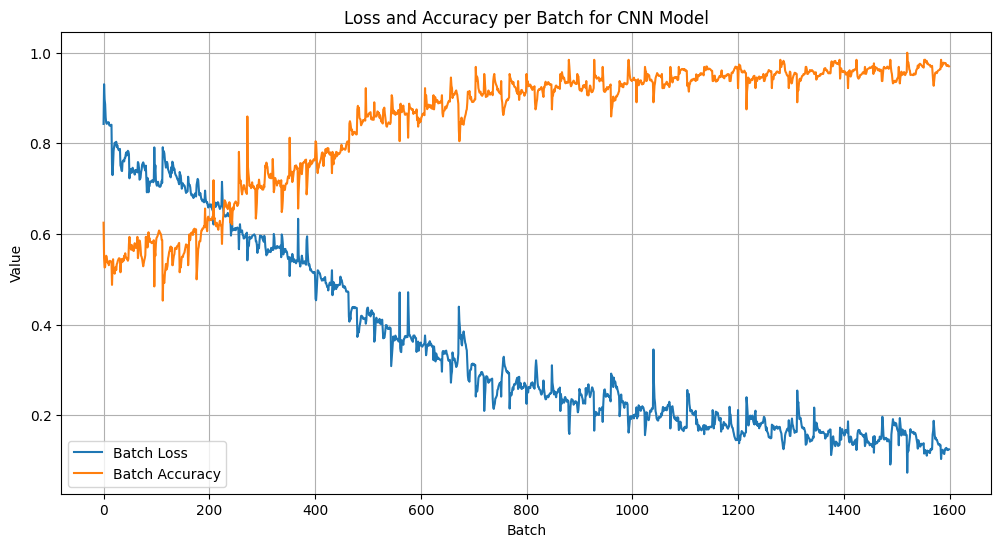

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='loss', label='Batch Loss')
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='accuracy', label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Batch for CNN Model')
plt.grid()
plt.legend()
plt.savefig(cnn_model_dir+'loss&accurcay per batch', format='png')
plt.show()

In [ ]:
epoch_scores_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.841022,0.539062,0.720340,0.468401
1,0.787839,0.544456,0.725392,0.468401
2,0.781926,0.545455,0.729756,0.468401
3,0.741110,0.572428,0.736004,0.468401
4,0.739917,0.553447,0.742045,0.468401


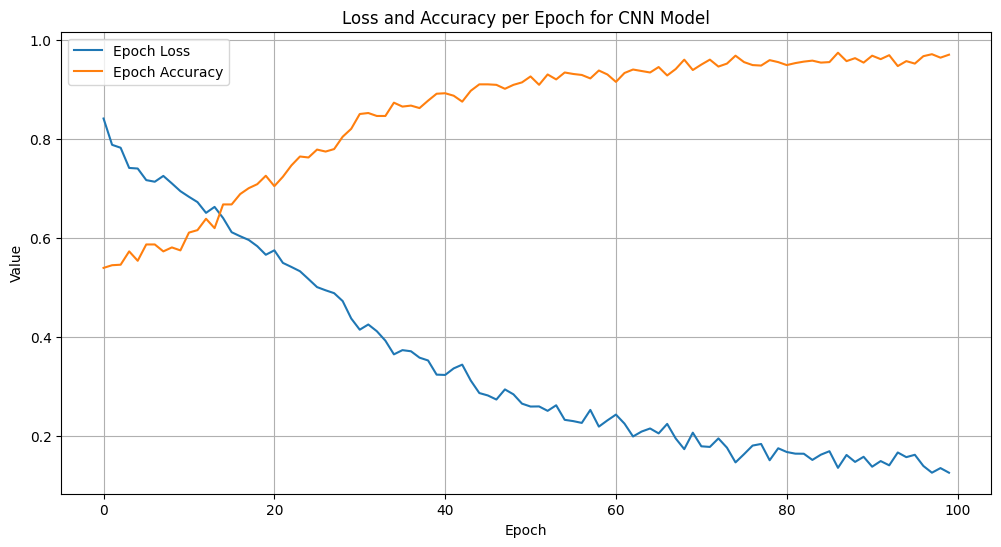

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='loss', label='Epoch Loss')
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='accuracy', label='Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch for CNN Model')
plt.grid()
plt.legend()
plt.savefig(cnn_model_dir+'loss&accurcay per epoch', format='png')
plt.show()

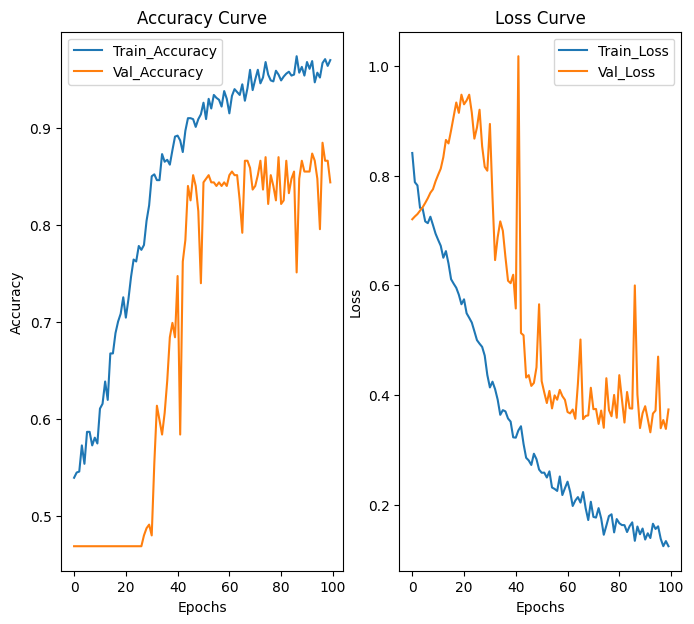

In [ ]:
plt.figure(figsize=(8, 7))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(cnn_model_history.epoch, cnn_model_history.history['accuracy'], label='Train_Accuracy')
plt.plot(cnn_model_history.epoch, cnn_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(cnn_model_history.epoch, cnn_model_history.history['loss'], label='Train_Loss')
plt.plot(cnn_model_history.epoch, cnn_model_history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig(cnn_model_dir+'cnn_model_History_Plot', format='png')

In [ ]:
cnn_pred = cnn_model.predict(val_sentences)
cnn_pred = tf.round(cnn_pred)

9/9 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(val_labels, cnn_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       143
           1       0.89      0.76      0.82       126

    accuracy                           0.84       269
   macro avg       0.85      0.84      0.84       269
weighted avg       0.85      0.84      0.84       269



classification report for cnn model

In [ ]:
cnn_model_score = accuracy_score(val_labels, cnn_pred)
print(f'The CNN Model achieves an accuracy of: {cnn_model_score*100:.2f}% on tha validation dataset')

The CNN Model achieves an accuracy of: 84.39% on tha validation dataset


#### Dense Neural Network

In [ ]:
dnn_model_dir = _dnn_model_dir

In [ ]:
## Fit the model

# callback to record the score for each batch and epoch
class BatchAndEpochRecorder(Callback):
    def __init__(self):
        super(BatchAndEpochRecorder, self).__init__()
        self.batch_scores = []
        self.epoch_scores = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_scores.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_scores.append(logs)

# Dense Layer Model Architecture Construction
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
vectorizer = text_vectorizer_layer(inputs)
embedding = embedding_layer(vectorizer)
x = tf.keras.layers.Dense(16, activation='tanh')(embedding)
x = tf.keras.layers.Dense(32, activation='tanh')(x)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='ouput_dense_layer')(x)
dense_model = tf.keras.Model(inputs, outputs, name='Dense_Model')


## Compile the model
dense_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Create an instance of the custom callback
recorder = BatchAndEpochRecorder()

# Set Model Training Callbacks
save_best_model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=dnn_model_dir+'Tweet_Classifier', verbose=1, save_best_only=True)

# Train the model with the specified batch size and epochs, and using the custom callback
dense_model_history = dense_model.fit(x=shuffled_sentences,
                                      y=shuffled_labels,
                                      steps_per_epoch=len(shuffled_sentences)//64,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(val_sentences, val_labels),
                                      callbacks=[recorder, save_best_model_ckpt])

# After training, the recorded scores can be accessed
batch_scores_df = pd.DataFrame(recorder.batch_scores)
epoch_scores_df = pd.DataFrame(recorder.epoch_scores)

# Optionally, save the scores to CSV files
batch_scores_df.to_csv(dnn_model_dir+'batch_scores.csv', index=False)
epoch_scores_df.to_csv(dnn_model_dir+'epoch_scores.csv', index=False)

# Print the first few rows to check
print(batch_scores_df.head())
print(epoch_scores_df.head())

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.5332
Epoch 1: val_loss improved from inf to 0.68464, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/DNN_Model_Output/Tweet_Classifier
16/16 [==============================] - 12s 400ms/step - loss: 0.6885 - accuracy: 0.5332 - val_loss: 0.6846 - val_accuracy: 0.5316
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.6094
Epoch 2: val_loss improved from 0.68464 to 0.64534, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/DNN_Model_Output/Tweet_Classifier
16/16 [==============================] - 3s 172ms/step - loss: 0.6684 - accuracy: 0.6094 - val_loss: 0.6453 - val_accuracy: 0.6877
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.7892
Epoch 3: val_loss improved from 0.64534 to 0.52734, saving model to /content/drive/MyDrive/Col

##### Visualize Score for Each Batch Size & Epoch

In [ ]:
batch_scores_df.head()

,loss,accuracy
0,0.695773,0.421875
1,0.694519,0.468750
2,0.693978,0.484375
3,0.692221,0.515625
4,0.692379,0.512500


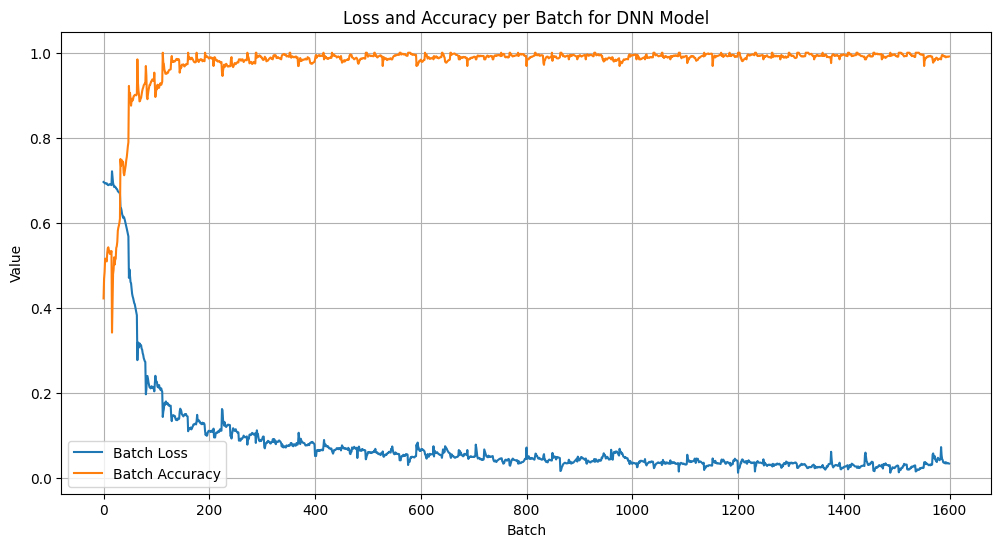

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='loss', label='Batch Loss')
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='accuracy', label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Batch for DNN Model')
plt.grid()
plt.legend()
plt.savefig(dnn_model_dir+'loss&accurcay per batch', format='png')
plt.show()

In [ ]:
epoch_scores_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.688481,0.533203,0.684637,0.531599
1,0.668441,0.609391,0.645342,0.687732
2,0.567751,0.789211,0.527340,0.840149
3,0.382240,0.903097,0.419516,0.836431
4,0.272484,0.927073,0.396307,0.802974


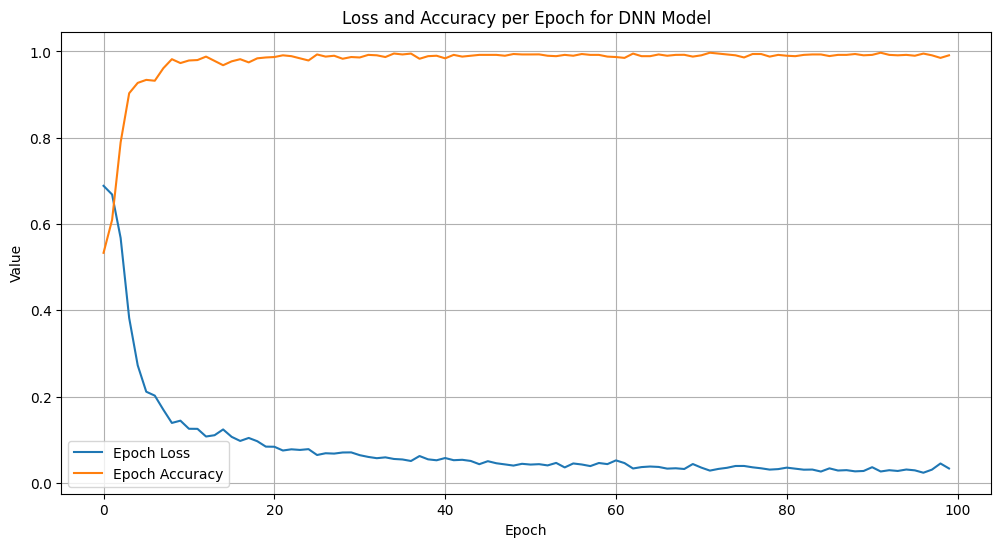

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='loss', label='Epoch Loss')
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='accuracy', label='Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch for DNN Model')
plt.grid()
plt.legend()
plt.savefig(dnn_model_dir+'loss&accurcay per epoch', format='png')
plt.show()

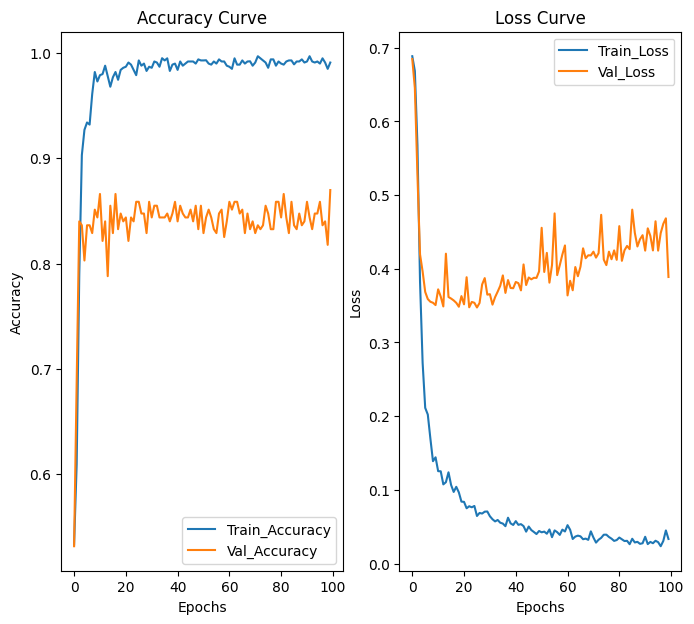

In [ ]:
plt.figure(figsize=(8, 7))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(dense_model_history.epoch, dense_model_history.history['accuracy'], label='Train_Accuracy')
plt.plot(dense_model_history.epoch, dense_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(dense_model_history.epoch, dense_model_history.history['loss'], label='Train_Loss')
plt.plot(dense_model_history.epoch, dense_model_history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig(dnn_model_dir+'dnn_model_History_Plot', format='png')

In [ ]:
dnn_pred = dense_model.predict(val_sentences)
dnn_pred = tf.round(dnn_pred)

9/9 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(val_labels, dnn_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       143
           1       0.85      0.87      0.86       126

    accuracy                           0.87       269
   macro avg       0.87      0.87      0.87       269
weighted avg       0.87      0.87      0.87       269



classification report for Dense Model

In [ ]:
dnn_model_score = accuracy_score(val_labels, dnn_pred)
print(f'The DNN Layer Model achieves an accuracy of: {dnn_model_score*100:.2f}% on the validation dataset')

The DNN Layer Model achieves an accuracy of: 86.99% on the validation dataset


#### GRU - Gated Recurrent Unit

In [ ]:
GRU_model_dir = _GRU_model_dir

In [ ]:
## Fit the model

# callback to record the score for each batch and epoch
class BatchAndEpochRecorder(Callback):
    def __init__(self):
        super(BatchAndEpochRecorder, self).__init__()
        self.batch_scores = []
        self.epoch_scores = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_scores.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_scores.append(logs)

# GRU RNN Layer Model Architecture Construction
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vectorizer = text_vectorizer_layer(inputs)
embedding = embedding_layer(vectorizer)
x = tf.keras.layers.GRU(8, activation='tanh', return_sequences=True, recurrent_dropout=0.5)(embedding)
x = tf.keras.layers.GRU(8, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001), recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output_dense_layer')(x)
GRU_Model = tf.keras.Model(inputs, output, name='GRU_model')

## Compile the model
GRU_Model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0500),
                    metrics=['accuracy'])

# Create an instance of the custom callback
recorder = BatchAndEpochRecorder()

# Set Model Training Callbacks
save_best_model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=GRU_model_dir+'Tweet_Classifier', verbose=1, save_best_only=True)

# Train the model with the specified batch size and epochs, and using the custom callback
GRU_model_history = GRU_Model.fit(x=shuffled_sentences,
                                  y=shuffled_labels,
                                  steps_per_epoch=len(shuffled_sentences)//128,
                                  epochs=100,
                                  batch_size=64,
                                  validation_data=(val_sentences, val_labels),
                                  callbacks=[recorder, save_best_model_ckpt],
                                  verbose=1)

# After training, the recorded scores can be accessed
batch_scores_df = pd.DataFrame(recorder.batch_scores)
epoch_scores_df = pd.DataFrame(recorder.epoch_scores)

# Optionally, save the scores to CSV files
batch_scores_df.to_csv(GRU_model_dir+'batch_scores.csv', index=False)
epoch_scores_df.to_csv(GRU_model_dir+'epoch_scores.csv', index=False)

# Print the first few rows to check
print(batch_scores_df.head())
print(epoch_scores_df.head())

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5938
Epoch 1: val_loss improved from inf to 0.61407, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/GRU_Model/Tweet_Classifier
8/8 [==============================] - 14s 977ms/step - loss: 0.6864 - accuracy: 0.5938 - val_loss: 0.6141 - val_accuracy: 0.6840
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8047
Epoch 2: val_loss improved from 0.61407 to 0.58269, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/GRU_Model/Tweet_Classifier
8/8 [==============================] - 32s 4s/step - loss: 0.4692 - accuracy: 0.8047 - val_loss: 0.5827 - val_accuracy: 0.7398
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8569
Epoch 3: val_loss improved from 0.58269 to 0.44536, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classi

In [ ]:
batch_scores_df.head()

,loss,accuracy
0,0.732214,0.546875
1,0.782005,0.531250
2,0.771519,0.520833
3,0.754077,0.515625
4,0.731562,0.540625


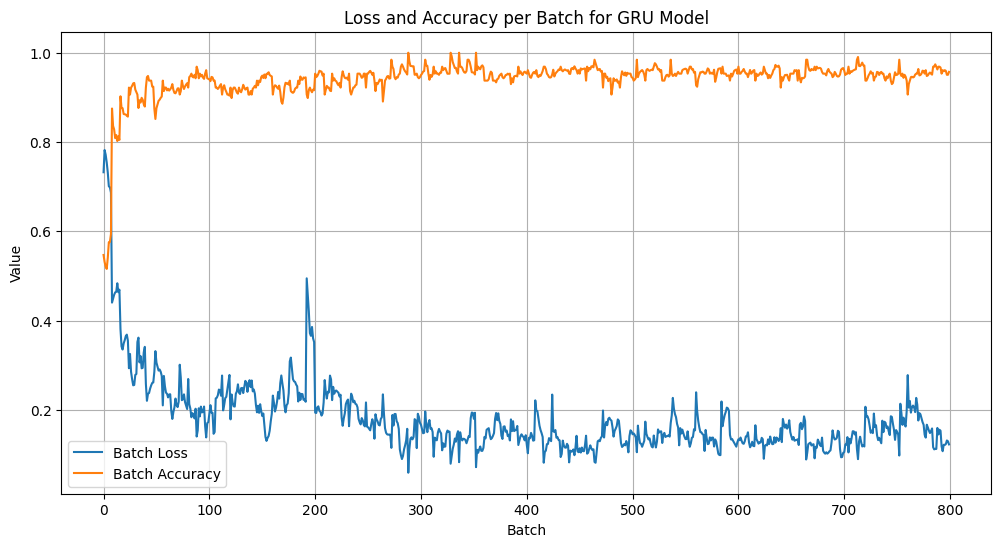

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='loss', label='Batch Loss')
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='accuracy', label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Batch for GRU Model')
plt.grid()
plt.legend()
plt.savefig(GRU_model_dir+'loss&accurcay per batch', format='png')
plt.show()

In [ ]:
epoch_scores_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.686356,0.593750,0.614072,0.684015
1,0.469157,0.804688,0.582688,0.739777
2,0.354910,0.856851,0.445360,0.810409
3,0.280016,0.912109,0.444840,0.847584
4,0.341037,0.879346,0.417108,0.840149


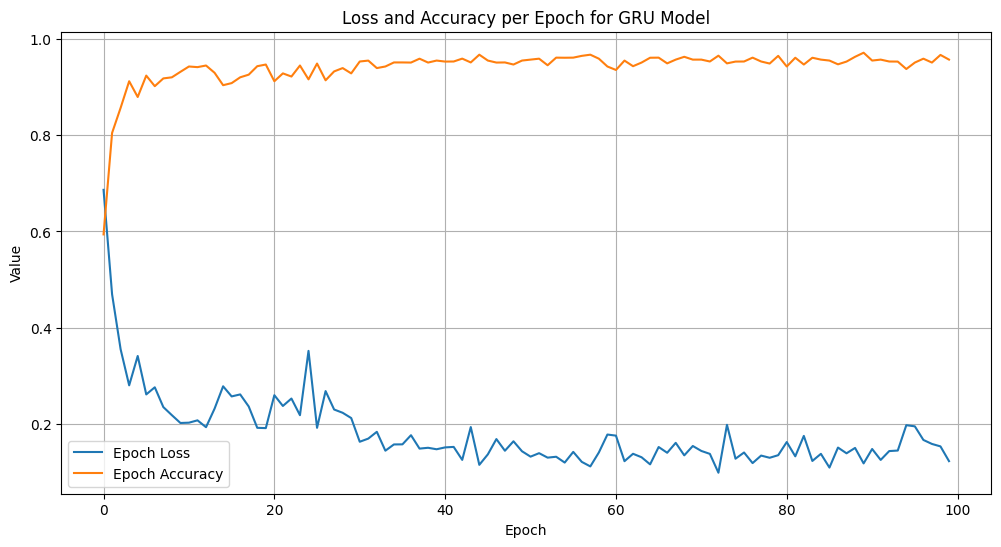

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='loss', label='Epoch Loss')
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='accuracy', label='Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy per Epoch for GRU Model')
plt.grid()
plt.legend()
plt.savefig(GRU_model_dir+'loss&accurcay per epoch', format='png')
plt.show()

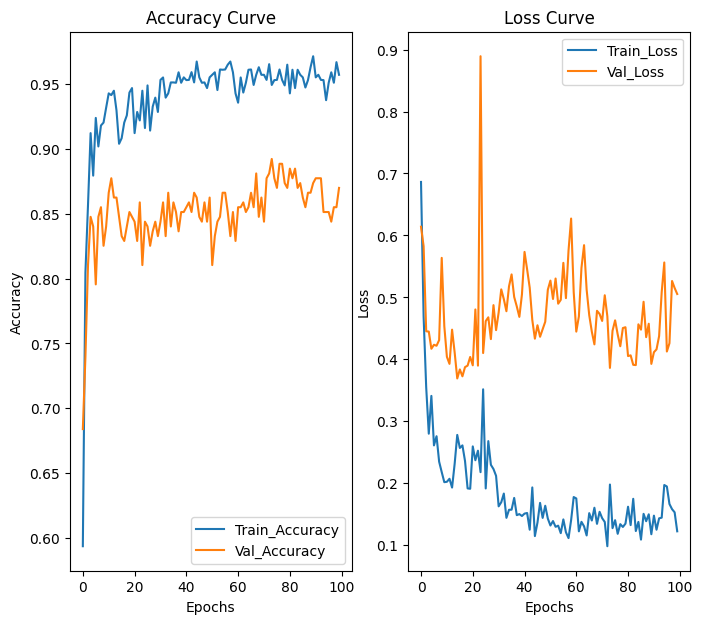

In [ ]:
plt.figure(figsize=(8, 7))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(GRU_model_history.epoch, GRU_model_history.history['accuracy'], label='Train_Accuracy')
plt.plot(GRU_model_history.epoch, GRU_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(GRU_model_history.epoch, GRU_model_history.history['loss'], label='Train_Loss')
plt.plot(GRU_model_history.epoch, GRU_model_history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig(GRU_model_dir+'GRU_Model_History_Plot', format='png')

In [ ]:
gru_pred = GRU_Model.predict(val_sentences)
gru_pred = tf.round(gru_pred)

9/9 [==============================] - 1s 17ms/step


In [ ]:
print(classification_report(val_labels, gru_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       143
           1       0.86      0.86      0.86       126

    accuracy                           0.87       269
   macro avg       0.87      0.87      0.87       269
weighted avg       0.87      0.87      0.87       269



classification report for GRU Model

In [ ]:
gru_model_score = accuracy_score(val_labels, gru_pred)
print(f'The GRU Model Achieves an Accuracy of {gru_model_score*100:.2f}% on the Validation Dataset')

The GRU Model Achieves an Accuracy of 86.99% on the Validation Dataset


#### LSTM - Long Short Term Memory

In [ ]:
## Fit the model

# callback to record the score for each batch and epoch
class BatchAndEpochRecorder(Callback):
    def __init__(self):
        super(BatchAndEpochRecorder, self).__init__()
        self.batch_scores = []
        self.epoch_scores = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_scores.append(logs)

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_scores.append(logs)

# GRU RNN Layer Model Architecture Construction
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vectorizer = text_vectorizer_layer(inputs)
embedding = embedding_layer(vectorizer)
x = tf.keras.layers.LSTM(8, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001), recurrent_dropout=0.2)(embedding)
x = tf.keras.layers.LSTM(16, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001), recurrent_dropout=0.2)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='output_dense_layer')(x)
LSTM_Model = tf.keras.Model(inputs, output, name='LSTM_model')

## Compile the model
LSTM_Model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00010),
                    metrics=['accuracy'])

# Create an instance of the custom callback
recorder = BatchAndEpochRecorder()

# Set Model Training Callbacks
save_best_model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=_LSTM_model_dir+'Tweet_Classifier', verbose=1, save_best_only=True)

# Train the model with the specified batch size and epochs, and using the custom callback
LSTM_model_history = LSTM_Model.fit(x=shuffled_sentences,
                                    y=shuffled_labels,
                                    epochs=100,
                                    steps_per_epoch=len(shuffled_sentences)//128,
                                    batch_size=64,
                                    validation_data=(val_sentences, val_labels),
                                    callbacks=[recorder, save_best_model_ckpt])

# After training, the recorded scores can be accessed
batch_scores_df = pd.DataFrame(recorder.batch_scores)
epoch_scores_df = pd.DataFrame(recorder.epoch_scores)

# Optionally, save the scores to CSV files
batch_scores_df.to_csv(_LSTM_model_dir+'batch_scores.csv', index=False)
epoch_scores_df.to_csv(_LSTM_model_dir+'epoch_scores.csv', index=False)

# Print the first few rows to check
print(batch_scores_df.head())
print(epoch_scores_df.head())

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.7871 - accuracy: 0.4277
Epoch 1: val_loss improved from inf to 0.78336, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/LSTM_model_output/Tweet_Classifier
8/8 [==============================] - 57s 871ms/step - loss: 0.7871 - accuracy: 0.4277 - val_loss: 0.7834 - val_accuracy: 0.4535
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.4707
Epoch 2: val_loss improved from 0.78336 to 0.78033, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/LSTM_model_output/Tweet_Classifier
8/8 [==============================] - 7s 994ms/step - loss: 0.7701 - accuracy: 0.4707 - val_loss: 0.7803 - val_accuracy: 0.4535
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.7726 - accuracy: 0.4397
Epoch 3: val_loss improved from 0.78033 to 0.77774, saving model to /content/drive/MyDrive/Colab Noteb

In [ ]:
batch_scores_df.head()

,loss,accuracy
0,0.781425,0.484375
1,0.784171,0.476562
2,0.779892,0.489583
3,0.784741,0.460938
4,0.787617,0.440625


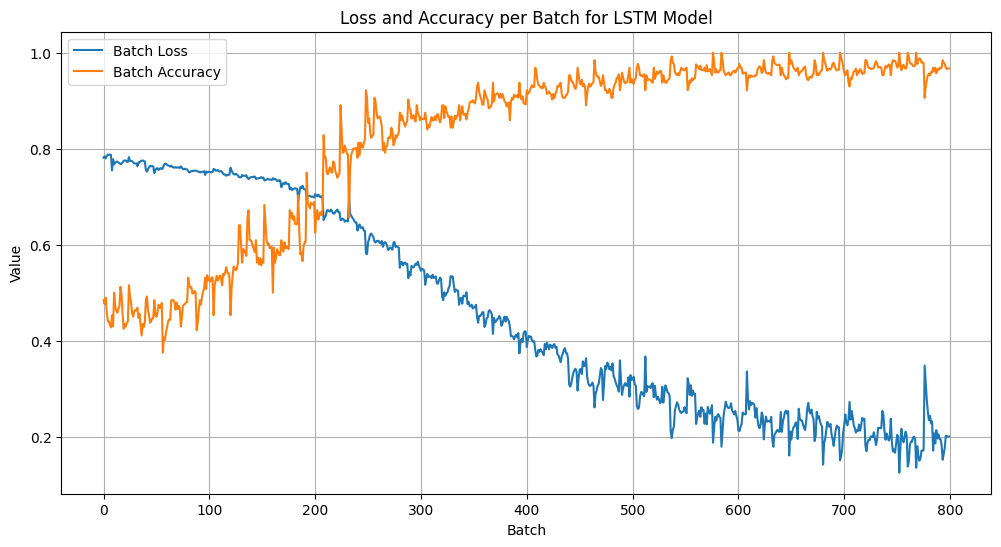

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='loss', label='Batch Loss')
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='accuracy', label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Loss and Accuracy per Batch for LSTM Model')
plt.savefig(_LSTM_model_dir+'Training_Batch_Loss&Acc_Curve', format='png')
plt.show()

In [ ]:
epoch_scores_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.787099,0.427734,0.783362,0.453532
1,0.770067,0.470703,0.780326,0.453532
2,0.772574,0.439673,0.777743,0.460967
3,0.769238,0.462891,0.775236,0.453532
4,0.773521,0.437628,0.772985,0.468401


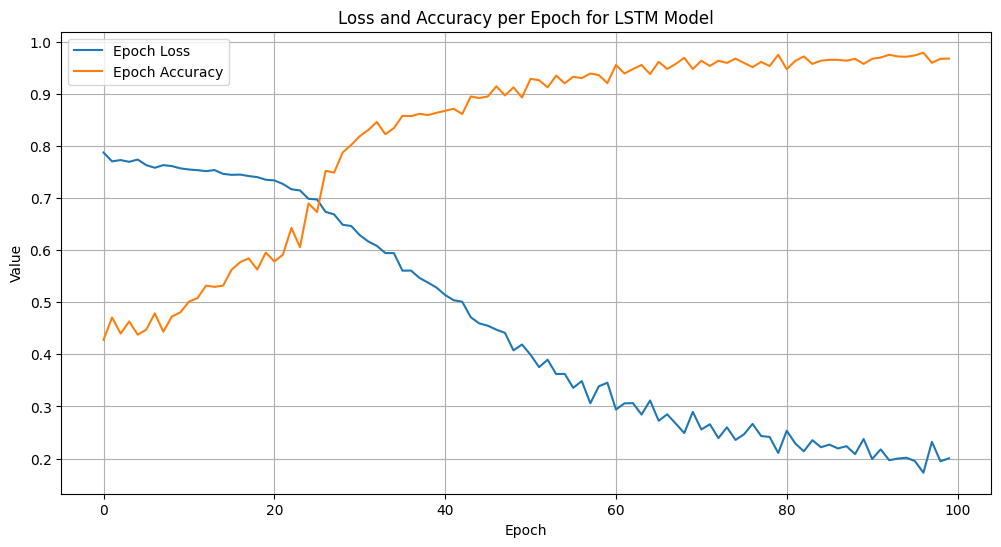

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='loss', label='Epoch Loss')
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='accuracy', label='Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.title('Loss and Accuracy per Epoch for LSTM Model')
plt.savefig(_LSTM_model_dir+'Training_Epoch_Loss&Acc_Curve', format='png')
plt.show()

<ipython-input-89-b402ad7c20a4>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


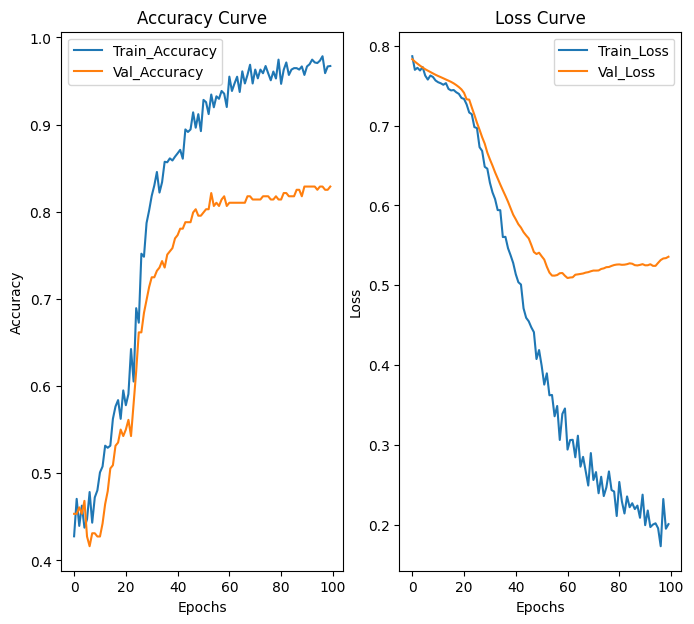

In [ ]:
plt.figure(figsize=(8, 7))
plt.title('Training Accuracy and Loss Curve')
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(LSTM_model_history.epoch, LSTM_model_history.history['accuracy'], label='Train_Accuracy')
plt.plot(LSTM_model_history.epoch, LSTM_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(LSTM_model_history.epoch, LSTM_model_history.history['loss'], label='Train_Loss')
plt.plot(LSTM_model_history.epoch, LSTM_model_history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig(_LSTM_model_dir+'LSTM_Model_History_Plot', format='png')

In [ ]:
LSTM_pred =LSTM_Model.predict(val_sentences)
LSTM_pred =tf.round(LSTM_pred)

9/9 [==============================] - 4s 102ms/step


In [ ]:
print(classification_report(y_true=val_labels, y_pred=LSTM_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       143
           1       0.85      0.77      0.81       126

    accuracy                           0.83       269
   macro avg       0.83      0.83      0.83       269
weighted avg       0.83      0.83      0.83       269



Classification Report For LSTM Model

In [ ]:
LSTM_model_score = accuracy_score(val_labels, LSTM_pred)
print(f'The LSTM Model Achieves an Accuracy of {LSTM_model_score*100:.2f}% on the Validation Dataset')

The LSTM Model Achieves an Accuracy of 82.90% on the Validation Dataset


#### BiLSTM - BiDirectional Long Short Term Memory

In [ ]:
## Fit the BiLSTM Model

## Create callback class for recording scores
class BatchAndEpochRecoder(Callback):
  def __init__(self):
    super(BatchAndEpochRecoder, self).__init__()
    self.batch_scores = []
    self.epoch_scores = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_scores.append(logs)

  def on_epoch_end(self, epoch, logs=None):
    self.epoch_scores.append(logs)

# Model Architecture Construction
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vectorizer = text_vectorizer_layer(inputs)
embedding = embedding_layer(vectorizer)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, activation='tanh', recurrent_dropout=0.2))(embedding)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001), recurrent_dropout=0.2))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(x)
bilstm_model = tf.keras.Model(inputs, outputs, name='BiLSTM_Model')

# Compile Model
bilstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.00050),
                     metrics=['accuracy'])

# Set Callback
recorder = BatchAndEpochRecoder()

# save model checkpoint
save_bilstm_model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=_Bilstm_model_dir+'Tweet_Classifier2', save_best_only=True, verbose=1)

#Fit BiLSTM Model
bilstm_model_history = bilstm_model.fit(x=shuffled_sentences,
                                        y=shuffled_labels,
                                        epochs=100,
                                        steps_per_epoch=len(shuffled_sentences)//128,
                                        validation_data=(val_sentences, val_labels),
                                        callbacks=[recorder, save_bilstm_model_ckpt])

# Access Recorded Scores After Traning
batch_scores_df = pd.DataFrame(recorder.batch_scores)
epoch_scores_df = pd.DataFrame(recorder.epoch_scores)

# Save Recorded Batch Scores to Disk
batch_scores_df.to_csv(_Bilstm_model_dir+'batch_scores.csv', index=False)
epoch_scores_df.to_csv(_Bilstm_model_dir+'epoch_scores.csv', index=False)

# Print the first few rows to check
print(batch_scores_df.head())
print(epoch_scores_df.head())

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.5079
Epoch 1: val_loss improved from inf to 0.73852, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/BiLSTM_model_output/Tweet_Classifier2
12/12 [==============================] - 31s 2s/step - loss: 0.7423 - accuracy: 0.5079 - val_loss: 0.7385 - val_accuracy: 0.5645
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.5917
Epoch 2: val_loss improved from 0.73852 to 0.73231, saving model to /content/drive/MyDrive/Colab Notebooks/Binary_Classification_of_Tweets/Outputs/BiLSTM_model_output/Tweet_Classifier2
12/12 [==============================] - 19s 2s/step - loss: 0.7359 - accuracy: 0.5917 - val_loss: 0.7323 - val_accuracy: 0.5718
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.5917
Epoch 3: val_loss improved from 0.73231 to 0.72478, saving model to /content/drive/MyDrive/

In [ ]:
batch_scores_df.head()

,loss,accuracy
0,0.744941,0.481752
1,0.744781,0.452555
2,0.744537,0.457421
3,0.744269,0.461679
4,0.743945,0.470073


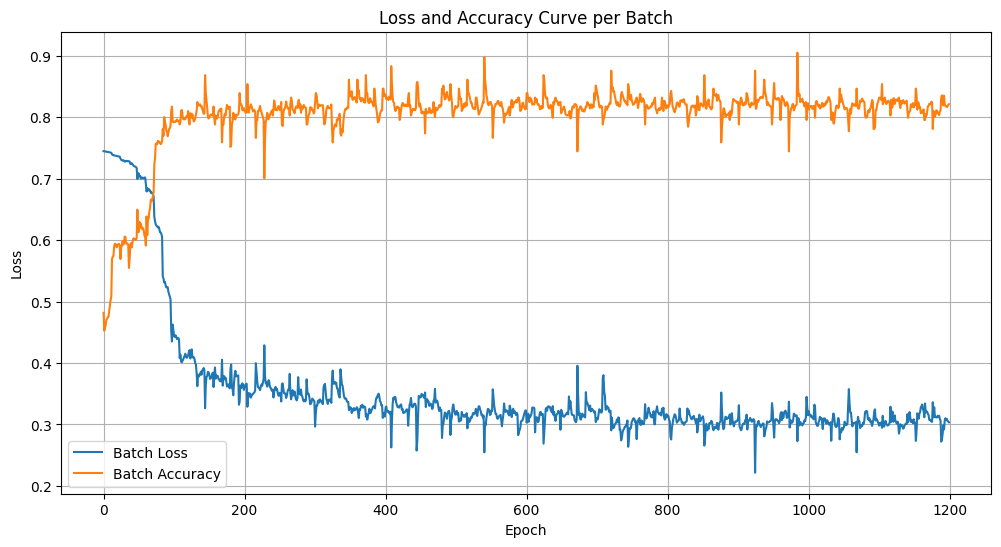

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='loss', label='Batch Loss')
sns.lineplot(data=batch_scores_df, x=batch_scores_df.index, y='accuracy', label='Batch Accuracy')
plt.grid()
plt.legend()
plt.title('Loss and Accuracy Curve per Batch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(_Bilstm_model_dir+'Training_Batch_Loss&Acc_Curve', format='png')
plt.show()

In [ ]:
epoch_scores_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.742277,0.507946,0.738516,0.564477
1,0.735885,0.591687,0.732313,0.571776
2,0.728777,0.591687,0.724784,0.574209
3,0.717152,0.603912,0.715020,0.588808
4,0.701900,0.605134,0.699406,0.605839


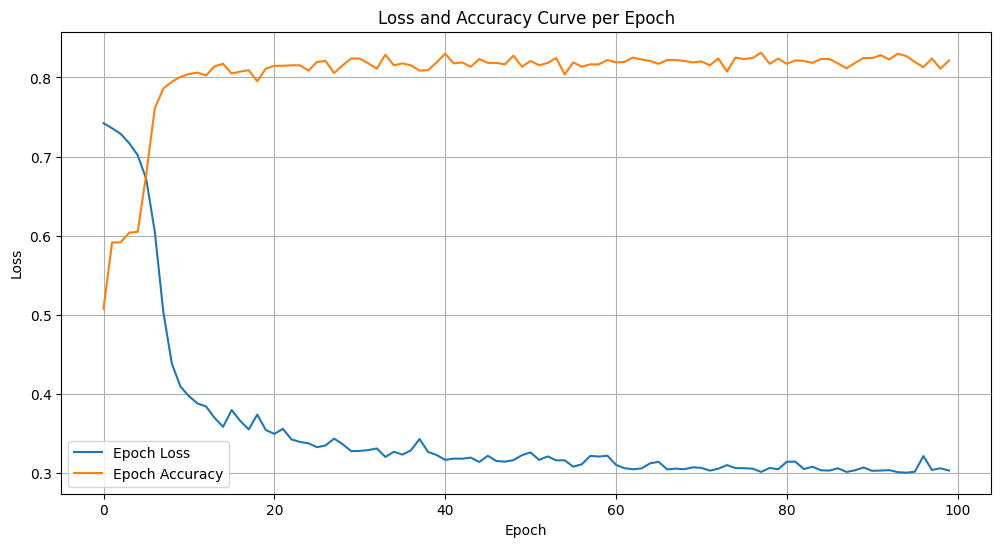

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='loss', label='Epoch Loss')
sns.lineplot(data=epoch_scores_df, x=epoch_scores_df.index, y='accuracy', label='Epoch Accuracy')
plt.grid()
plt.legend()
plt.title('Loss and Accuracy Curve per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(_Bilstm_model_dir+'Training_Epoch_Loss&Acc_Curve', format='png')
plt.show()

<ipython-input-162-110606cf4180>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


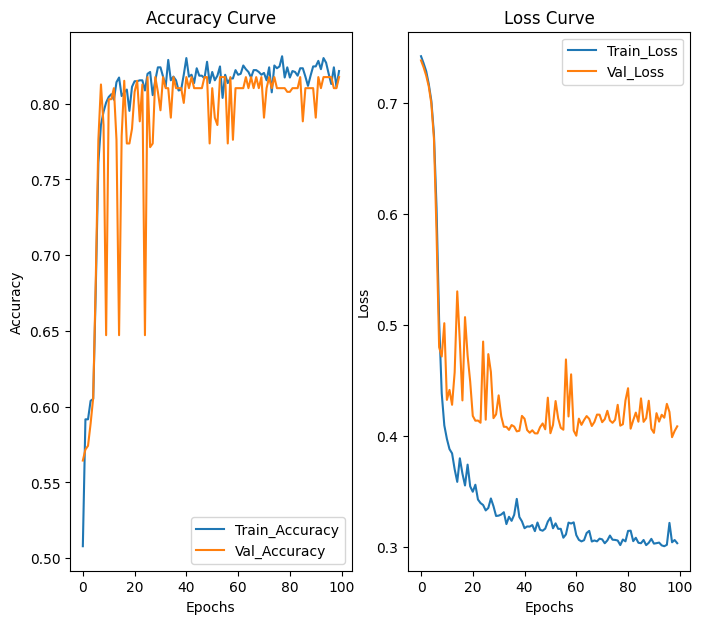

In [ ]:
plt.figure(figsize=(8, 7))
plt.title('Training Accuracy and Loss Curve')
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(bilstm_model_history.epoch, bilstm_model_history.history['accuracy'], label='Train_Accuracy')
plt.plot(bilstm_model_history.epoch, bilstm_model_history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();
plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(bilstm_model_history.epoch, bilstm_model_history.history['loss'], label='Train_Loss')
plt.plot(bilstm_model_history.epoch, bilstm_model_history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
plt.savefig(_Bilstm_model_dir+'BiLSTM_Model_History_Plot', format='png')

In [ ]:
bilstm_pred = tf.round(bilstm_model.predict(val_sentences))

13/13 [==============================] - 1s 12ms/step


In [ ]:
print(classification_report(val_labels, bilstm_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       208
           1       0.82      0.81      0.81       203

    accuracy                           0.82       411
   macro avg       0.82      0.82      0.82       411
weighted avg       0.82      0.82      0.82       411



Classification Report for BiLSTM Model

In [ ]:
BiLSTM_model_score = accuracy_score(val_labels, bilstm_pred)
print(f'The BiLSTM Model Achieved an Accuracy of {BiLSTM_model_score*100:.2f}% on the Validation Dataset')

The BiLSTM Model Achieved an Accuracy of 81.75% on the Validation Dataset


## Model Performance Evaluation

In [ ]:
saved_cnn_model = tf.keras.models.load_model(_cnn_model_dir+'Tweet_Classifier')
saved_dnn_model = tf.keras.models.load_model(_dnn_model_dir+'Tweet_Classifier')
saved_gru_model = tf.keras.models.load_model(_GRU_model_dir+'Tweet_Classifier')
saved_lstm_model = tf.keras.models.load_model(_LSTM_model_dir+'Tweet_Classifier')
saved_bilstm_model = tf.keras.models.load_model(_Bilstm_model_dir+'/Tweet_Classifier')

In [ ]:
class ModelEvaluation():
  def __init__(self, saved_gru_model, saved_dnn_model, saved_cnn_model, saved_lstm_model, saved_bilstm_model):
    self.models = {
      'GRU_Model': saved_gru_model,
      'Dense_Model': saved_dnn_model,
      'CNN_Model': saved_cnn_model,
      'LSTM_Model':saved_lstm_model,
      'BiLSTM_Model':saved_bilstm_model
    }

  def evaluate_models(self, y_true, val_data):
      '''
      This function performs evaluation on multiple tweet classifier models.
      It returns a dictionary containing accuracy, precision, recall, and F1 score for each model.

      args:
      - y_true: The true labels
      - val_data: The validation data
      - models: A dictionary of models to evaluate with keys as model names and values as model objects
      '''
      results = {}

      for model_name, model in self.models.items():
          # Predict using the model
          y_pred = tf.round(model.predict(val_data))

          # Compute metrics
          accuracy = accuracy_score(y_true, y_pred)
          precision = precision_score(y_true, y_pred)
          recall = recall_score(y_true, y_pred)
          f1 = f1_score(y_true, y_pred)

          # Store the results in a dictionary
          results[model_name] = {
              'accuracy': accuracy,
              'precision': precision,
              'recall': recall,
              'f1 score': f1
          }

      return results

  def plot_multiple_confusion_matrices(self, y_true, val_data, save_path=None):
      '''
      This function plots and saves confusion matrices for multiple models.

      args:
      - y_true: The true labels
      - val_data: The validation data
      - models: A dictionary of models to evaluate with keys as model names and values as model objects
      - save_path: The path to save the confusion matrix plot
      '''
      num_models = len(self.models.keys())
      fig, axes = plt.subplots(1, num_models, figsize=(num_models * 6, 6))

      if num_models == 1:
          axes = [axes]

      for ax, (model_name, model) in zip(axes, self.models.items()):
          y_pred = tf.round(model.predict(val_data)).numpy().astype(int)
          conf_matrix = confusion_matrix(y_true, y_pred)

          sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                      xticklabels=['Predicted Disaster', 'Predicted Suicide'],
                      yticklabels=['Actual Disaster', 'Actual Suicide'],
                      ax=ax)

          ax.set_title(f'Confusion Matrix for {model_name}')
          ax.set_xlabel('Predicted Labels')
          ax.set_ylabel('True Labels')

      plt.tight_layout()
      if save_path is not None:
        plt.savefig(save_path, format='png')
      plt.show()

  def plot_multiple_roc_curves(self, val_data, y_true, save_path=None):
    num_models = len(self.models.keys())

    fig, axes = plt.subplots(1, num_models, figsize=(num_models*6, 6))
    if num_models == 1:
        axes = [axes]

    for ax, (model_name, model) in zip(axes,self.models.items()):
      y_pred_prob = model.predict(val_data)
      fpr, tpr, threshold = roc_curve(val_labels, np.squeeze(y_pred_prob))
      roc_auc = auc(fpr, tpr)
      ax.plot(fpr, tpr, label=f'ROC Curve for {model_name}')
      ax.plot([0, 1], [0, 1], 'r--', label='Random Guess')
      # Set labels and title
      ax.set_title(f'Area Under The Curve for {model_name} Tweet Classifier')
      ax.set_xlabel('False Positive Rate')
      ax.set_ylabel('True Positive Rate')
      ax.legend()

    plt.tight_layout()
    if save_path is not None:
      plt.savefig(save_path, format='png')
    plt.show()

In [ ]:
evaluation_results = ModelEvaluation(saved_gru_model, saved_dnn_model, saved_cnn_model, saved_lstm_model, saved_bilstm_model).evaluate_models(val_labels, val_sentences)

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(evaluation_results).T
results_df

12/12 [==============================] - 1s 12ms/step


,accuracy,precision,recall,f1 score
GRU_Model,0.802228,0.826087,0.755682,0.789318
Dense_Model,0.866295,0.823232,0.926136,0.871658
CNN_Model,0.874652,0.854054,0.897727,0.875346
LSTM_Model,0.818942,0.828402,0.795455,0.811594
BiLSTM_Model,0.908078,0.908571,0.903409,0.905983


In [ ]:
differences = results_df.sub(results_df.loc['BiLSTM_Model'], axis=1)

print("Differences between models:")
print(differences)

Differences between models:
              accuracy  precision    recall  f1 score
GRU_Model    -0.105850  -0.082484 -0.147727 -0.116665
Dense_Model  -0.041783  -0.085339  0.022727 -0.034325
CNN_Model    -0.033426  -0.054517 -0.005682 -0.030637
LSTM_Model   -0.089136  -0.080169 -0.107955 -0.094389
BiLSTM_Model  0.000000   0.000000  0.000000  0.000000


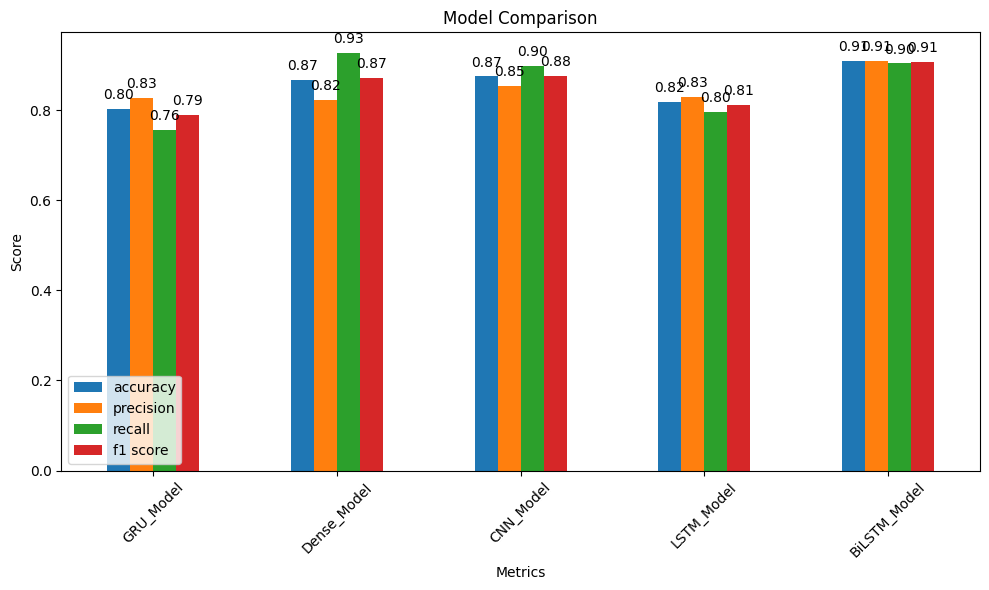

In [ ]:
# Plotting the results using matplotlib
import matplotlib.pyplot as plt

ax = results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower left')
# Add text annotations for each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig(_save_model_dir+'Model_Comparison_Plot', format='png')
plt.show()

The model comparison plot above illustrates that the BiLSTM model achieved the highest accuracy, at 89%, followed by the CNN model, with an accuracy of 87%. Meanwhile, the GRU model attained the highest precision score, reaching 90%. In terms of recall, the BiLSTM model outperformed the others, achieving a score of 90%. Additionally, the BiLSTM model also yielded the highest F1-score, standing at 89%.

12/12 [==============================] - 0s 12ms/step


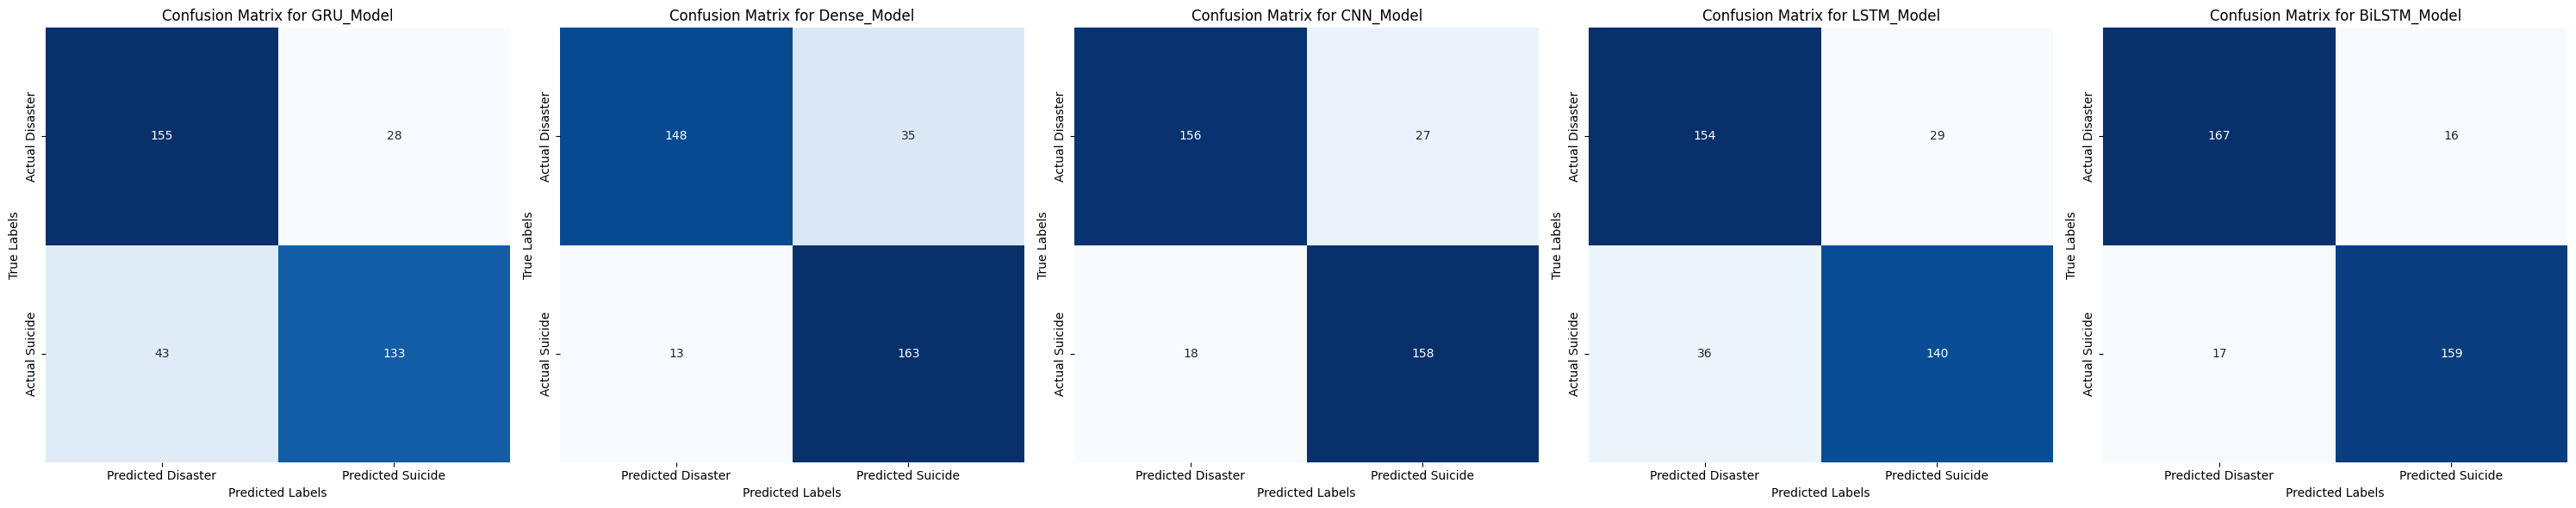

In [ ]:
ModelEvaluation(saved_gru_model, saved_dnn_model, saved_cnn_model, saved_lstm_model, saved_bilstm_model).plot_multiple_confusion_matrices(val_labels, val_sentences, save_path=_save_model_dir+'Confusion_Matrices')

The confusion matrix plot above provides a detailed overview of the performance of each of the five models. Utilizing evaluation metrics, it offers insights into how well the models performed on different classes of training data. Notably, the CNN model demonstrated superior accuracy in predicting disaster-related tweets compared to all other models. Similarly, the BiLSTM model exhibited exceptional accuracy in predicting suicide-related tweets, outperforming the other models in this aspect.

12/12 [==============================] - 0s 11ms/step


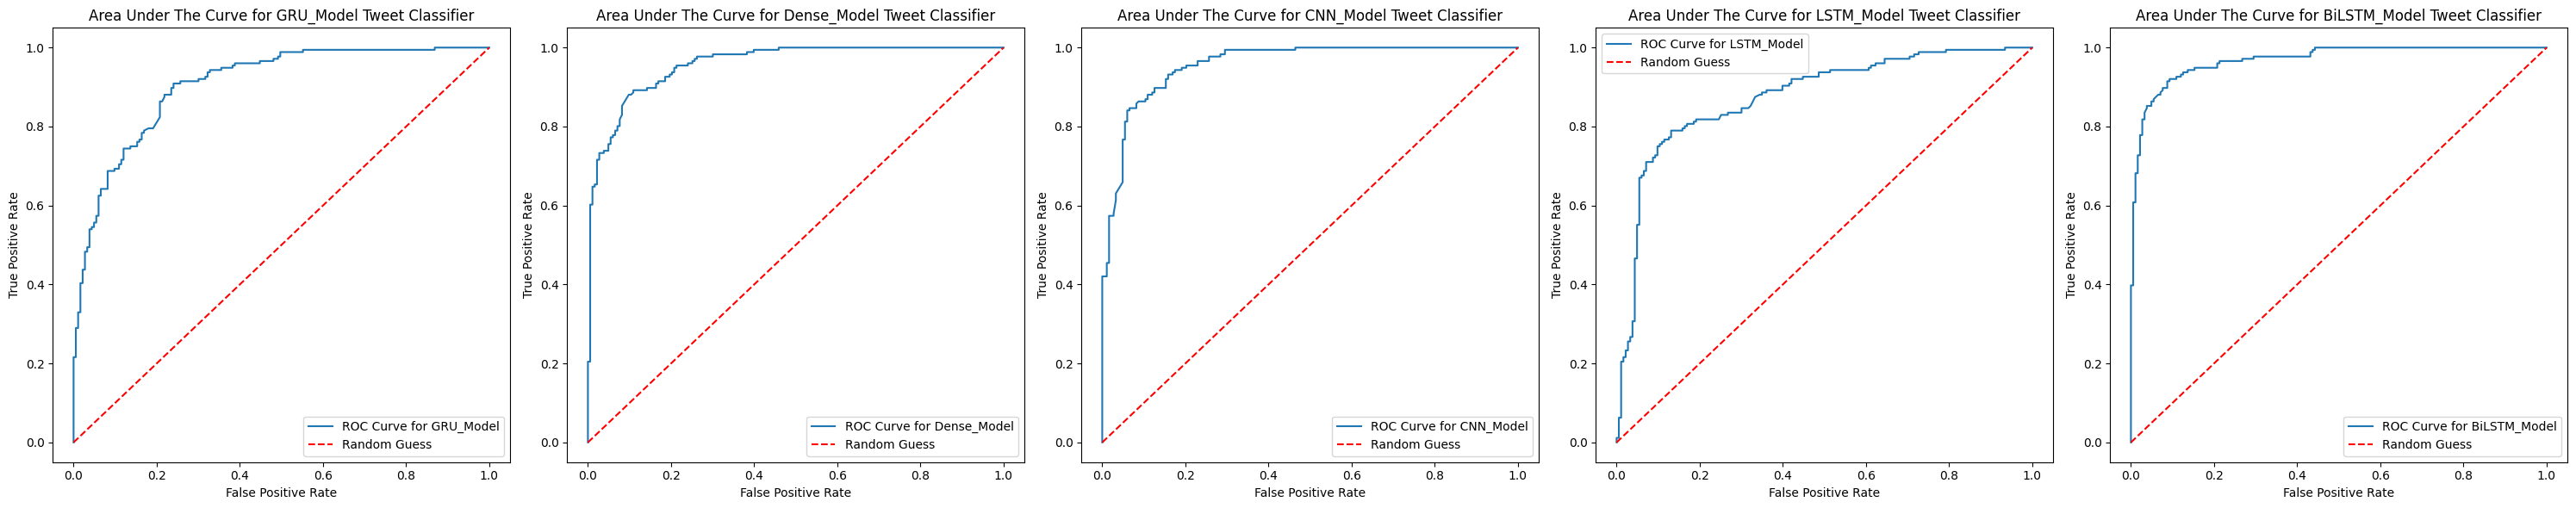

In [ ]:
ModelEvaluation(saved_gru_model, saved_dnn_model, saved_cnn_model, saved_lstm_model, saved_bilstm_model).plot_multiple_roc_curves(val_sentences, val_labels, save_path=_save_model_dir+'Roc_Curves')

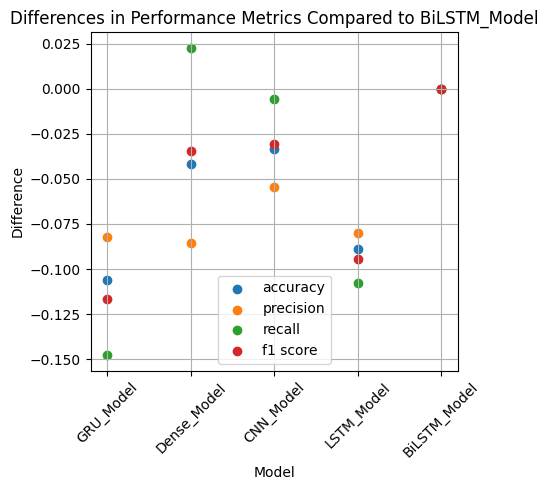

In [ ]:
plt.figure(figsize=(5,5))
for metric in differences.columns:
    plt.scatter(differences.index, differences[metric], label=metric)
plt.title('Differences in Performance Metrics Compared to BiLSTM_Model')
plt.ylabel('Difference')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(_save_model_dir+'Difference in Performance Plot', format='png')
plt.show()

12/12 [==============================] - 0s 20ms/step


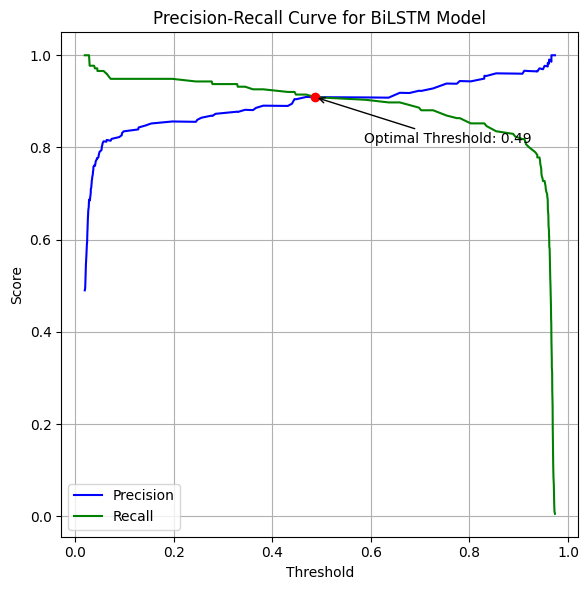

In [ ]:
bilstm_pred_probs = saved_bilstm_model.predict(val_sentences)
precisions, recalls, thresholds = precision_recall_curve(val_labels, bilstm_pred_probs)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot precision and recall curves
ax.plot(thresholds, precisions[:-1], label='Precision', color='blue')
ax.plot(thresholds, recalls[:-1], label='Recall', color='green')

# Set labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision-Recall Curve for BiLSTM Model')

# Highlight the intersection point of precision and recall curves
optimal_threshold = thresholds[np.argmax(precisions[:-1] == recalls[:-1])]
ax.plot(optimal_threshold, precisions[np.argmax(precisions[:-1] == recalls[:-1])], 'ro') # Red dot at optimal point
ax.annotate(f'Optimal Threshold: {optimal_threshold:.2f}',
            xy=(optimal_threshold, precisions[np.argmax(precisions[:-1] == recalls[:-1])]),
            xytext=(optimal_threshold + 0.1, precisions[np.argmax(precisions[:-1] == recalls[:-1])] - 0.1),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10)

# Add legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.savefig(_save_model_dir+'Precision_Recall_Curve', format='png')
plt.show()

In [ ]:
def plot_and_save_classification_report(y_true, y_pred, model_name, output_dir):
    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=False)

    # Save the report as a text file
    report_file = f'{output_dir}/{model_name}_classification_report.txt'
    with open(report_file, 'w') as f:
        f.write(f"Classification Report for {model_name}\n\n")
        f.write(report)

    # Load the report from the text file
    with open(report_file, 'r') as f:
        lines = f.readlines()

    # Add title and save as image
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.text(0.01, 0.95, f"Classification Report for {model_name}", transform=ax.transAxes, fontsize=14, fontweight='bold', va='top')
    report_text = ''.join(lines)
    ax.text(0.01, 0.5, report_text, transform=ax.transAxes, fontsize=12, va='top', family='monospace')
    ax.axis('off')

    # Save the image
    image_file = f'{output_dir}/{model_name}_classification_report.png'
    plt.savefig(image_file, bbox_inches='tight', pad_inches=0.5)
    plt.close()

def evaluate_and_plot_reports(models, model_names, X_test, y_test, output_dir):
    for model, model_name in zip(models, model_names):
        y_pred = model.predict(X_test)
        y_pred = tf.round(y_pred)
        plot_and_save_classification_report(y_test, y_pred, model_name, output_dir)

models = [saved_cnn_model, saved_dnn_model, saved_gru_model, saved_lstm_model, saved_bilstm_model]
model_names = ['CNN', 'DNN', 'GRU', 'LSTM', 'BiLSTM']

# Replace with your test data
X_test = val_sentences
y_test = val_labels

# Replace with your output directory
output_dir = _save_model_dir

evaluate_and_plot_reports(models, model_names, X_test, y_test, output_dir)

9/9 [==============================] - 0s 43ms/step


## Test Model using Custom Tweet

In [ ]:
# Import Classifier Model from disk
from config import _Bilstm_model_dir

_Bilstm_tweet_classifier_model = _Bilstm_model_dir+'Tweet_Classifier'

def classify_tweet(text):
  '''
  Function to perform tweet classification using the trained BiLSTM Model

  args:
   - text: the tweet to be classified
  '''
  # Import Model
  model = tf.keras.models.load_model(_Bilstm_tweet_classifier_model)
  # Make predictions using model
  pred = model.predict([text])
  # Round up prediction probability
  pred_num = tf.squeeze(np.round(pred).astype(int))
  # Convert Prediction into Class Label
  class_labels = ['Disaster', 'Suicide']
  pred_label = class_labels[pred_num]
  # Print out the predicted probabilites
  print(f'''
  Prediction Class: {pred_label}
        ''')

In [ ]:
classify_tweet('suicide is real')

1/1 [==============================] - 2s 2s/step

  Prediction Class: Suicide
        


In [ ]:
# Disaster
# still cannot believe does buildings collapsed
# I saw fire fighters running arounf to kill a fire
# in the car accident, many people died
# An accident just happened along lagos Ibadan expressway
# Landslide occured today along the highway
# So many houses got burnt, and many people lost thier lives today


# Suicide
# I am tired of life
# I hate this life
# the boy killed himself
# I am tired of being a burden to my family.
# Life has lost all its meaning for me
# I feel like I am stuck in a dark place.

## Test Model on User Interface: User Interface

In [3]:
!pip install streamlit
!pip install --upgrade py-localtunnel

In [4]:
# Generate tunnel password
!wget -q -O - ipv4.icanhazip.com

34.168.157.195


In [ ]:
!streamlit run Tweet_Classification_UI.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.168.157.195:8501

